# Credit Survival:
#A Deep Learning Approach with Time-Varying Covariates
#Bohdan Pryplotskyi, Fahad Ahmed, Maximilian Suliga
#Augst 31 2021


#**Abstract**

The article examines the potential of Dynamic DeepHit - a novel machine learning model – to handle Time-Varying Covariates in the credit risk context and compare its performance with Time-Varying Cox regression. Performing analysis on a large dataset of 50,000 US mortgage borrowers provides strong evidence in favour of both the models, where Dynamic DeepHit outperforms Time-Varying Cox model. We also perform an exercise to gauge the importance of variance in time-varying covariates by taking their averages across time, which, to our surprise, goes to show that time-variance did not matter too much for risk predictions made by Dynamic DeepHit, with the exception of one time-varying covariate – house price index – whose invariance yields worse results when compared to other time-varying features.

### Preliminaries

In [1]:
!git clone https://github.com/FahadahmedK/Dynamic-DeepHit #clone relevant .py files from github 

fatal: destination path 'Dynamic-DeepHit' already exists and is not an empty directory.


In [2]:
#importing all relevant packages and modules

!pip install lifelines

%tensorflow_version 1.x


#selecting working directory
import os
os.chdir('/content/Dynamic-DeepHit')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import random
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split
import sklearn 
from class_DeepLongitudinal import Model_Longitudinal_Attention
from utils_eval import c_index, brier_score
from utils_log import save_logging, load_logging
from utils_helper import f_get_minibatch, f_get_boosted_trainset
from lifelines import CoxTimeVaryingFitter
from lifelines import KaplanMeierFitter
from lifelines.utils import concordance_index

TensorFlow 1.x selected.


#  **Introduction**

Survival analysis is concerned with finding and understanding the relationship between the first hitting times of events (also called 'failure' depending on the context) and the covariates. It comprises statistical methods where the outcome variable is the first hitting time of an underlying stochastic process, also referred to as *survival time*, since we are interested in the time the subject has survived until the event first occurs over some follow-up period. For example, time to failure of a machine, patient survival time following onset of a disease, or time until a particular stock enters a bull market. With an appropriate dataset, we can examine the *risk factors* involved in the underlying stochastic process, thereby constructing a tool for risk assessment and risk management of the event of interest, which is the risk of loan defaults in our case. 

This paper aims to extend the static, binary classification problem of loan (or credit) default to consider whether a default is likely to occur, as well as, when a default is likely to occur. Therefore, our aim is to construct an empirical probability distribution over time. We employ competing-risk modelling, which models the event-time distributions for mutually-exclusive events, which are the risk of default and payoff before maturity in this context. 

Models on survival analysis typically call on the last available measurement to yield probabilities; however, data recorded is often longitudinal, that is, observations are collected at multiple time stamps for each subject. Such longitudinal data might contain information on the impact of evolution of (risk) factors, which could help on the event probabilities. It is therefore imperative to make use of such evolution in dynamic risk factors. To pursue this goal, we focus on incorporating the time-varying covariates directly into the model. If the relationship between such variables and the event probabilities depends on time, we hypothesize that the temporal importance of time-varying covariates will be significant. We borrow the work by (Lee, Yoon, & Schaar, 2020) on Dynamic DeepHit (DDH), which originally dealt with estimating risks for deaths due to respiratory failure, and extend it to the credit risk context. 

The notebook is organized as follows: Section 2 lays down some importance definitions and theory of survival analysis; Section 3 provides a brief review of a few classical and renowned state-of-the-art models in credit risk literature; Section 4 sets up the theoretical architecture of Dynamic DeepHit; Section 5
is divided into two parts: 1) Experiment with Time-Varying Cox Model, which we use as a benchmark against DDH, and 2) Experiment with Dynamic DeepHit. We then compare the results from both models on the basis of a time-varying Concordance Index and Brier Score. Lastly, we perform a variable importance exercise via an intra-model analysis that aims to assess the temporal importance of the time-varying features in our dataset. 



# **Foundations of Survival Analysis** 

We characterize the distribution of a random variable *t* (time) through
a survival function
$$S(t) = P(T >t) =  1 - F(t)  = \int_t^\infty f(z)dz$$ which gives the
cumulative probability of the event not occurring until *t*, where
$F(t) = \int_0^t f(z)dz$ is the cumulative distribution function of
the event, also known as the Cumulative Incidence Function (CIF) in the
survival literature. Next, we describe the hazard function
$$h(t)=\lim _{\delta t \rightarrow 0} \frac{\operatorname{Pr}(t \leq T \leq t+\delta t \mid T>t)}{\delta t}$$
that gives the instantaneous probability of experiencing the event,
given that the subject has survived until time *t*.


A common issue in Survival Analysis are so-called censored subjects. Censoring refers to the time of a subject that is not observed by the study, both before and after the study. The former is also referred to as left-censoring while the latter is referred to as right-censoring. As the occurence of an event can be usually excluded when the subject is able to be observed, right-censoring plays a bigger role in Survival Analysis since valuable information about the event happening to a subject is missing. Sources for right-censoring are the subject remaining event-free throughout the study, thr subject dropping out the study and the subject experiencing another event beforehand, as for example paying off the loan when the studied event is loan default.

# **Previous Models**

Below we discuss a few classical and state-of-the-art models in the survival analysis.

### **Kaplan-Meier Estimator**

One of the earliest approaches in modeling survival, the Kaplan-Meier
estimator (1958) is a non-parametric method giving insight about the
distribution of the observed population. The survival function is
calculated for each time step using the following formula:

$\hat{S(t)}=\prod_{i: t_{1} \le t} \frac{n_{i}-d_{i}}{n_{i}}$

with $n_{i}$ being the number of subjects at risk at time point $t$
and $d_{i}$ being the number of subjects that have experienced the
event till time point $t$. This univariate approach does not
incorporate any other covariates, hence all subjects are treated equally
rather than individually. This results in a constant probability of
survival for all subjects at any time $t$, regardless of individual
nature, time of appearance or censoring.

### **Cox Proportional Hazards Model**

The Cox Proportional Hazards Model (1972) is a semi-parametric approach
enabling the use of additional covariates.The hazard function is defined
as follows:

$h(t \mid X)=h_{0}(t) * \exp \left(\sum_{k=1}^{\varphi} \beta_{k} x_{k}\right)$

with $h_{0}(t)$ being the so-called baseline hazard and $x_{k}$
being the set of covariates, forming the so-called partial hazards. The
baseline hazard is the non-parametric, time-variant part of the
function, describing the value of hazard if all covariates are zero. It
is further the same for all subjects, as it does not incorporate
individual features. The partial hazard is the parametric part of the
function describing the partial effect of observed covariates on the
baseline hazard. As it is independent of time, the effect of covariates
is assumed to stay constant during all points of observation. This
implies independence between the event of interest of two subjects as
well as the survival curves of two subjects never crossing each other.
Moreover, the effect of the covariates is assumed to be linearly
additive.

### **Time Varying Cox Model**

The Cox Proportional Hazards Model may be modified in order to lift the
constant hazard ratio assumption. This allows the use of Time Varying
Covariates (TVCs). The conditional hazard function equals

$h(t|{X}) = P(T \in [t, t+\delta t) \mid T>t, {X}(t))$

The model remains parametric in part, pre-assuming a data distribution
which may justifiably be questioned. Despite incorporating more
potentially relevant information, results may still be possibly biased.

### **Deep Recurrent Survival Analysis**

Deep Recurrent Survival Analysis (DRSA) introduces a deep learning model for conditional probability prediction, which captures sequential patterns in the feature-time space. DRSA does not assume any specific form of the event
probability distribution and has a significant improvement against both
statistical and machine learning methods.

DRSA is based on Recurrent Neural Networks (RNN), whose idea first
emerged two decades ago. Its variants like long short-term memory
(LSTM) employ memory structures to
model the conditional probability which captures dynamic sequential
patterns (Hochreiter & Schmidhuber, 1997).

The RNN function takes $(\mathbf{x^i},\mathbf{t^l})$ as an input and
$\mathbf{h_l^i}$ as an output. $\mathbf{r^l}$ is the hidden vector
calculated from the RNN cell at the last time step which contains the
information about the conditional distribution.

### **Deephit**

Deephit (Lee, et al., 2018) is a multi-task network for survival analysis with competing
risks. Similar to other deep learning models, Deephit does not require
any assumption on event distribution. The model consists of two parts, a
shared sub-network and a family of cause-specific sub-networks.

The shared sub-network captures the representation that is common to *K*
competing events. The RNN input goes sequentially and creates a
hidden representation, which is used in cause-specific sub-networks.
Then the output of the shared sub-network and the original covariates
are passed to cause-specific sub-networks and the joint probability distribution for the event of interest is estimated using a softmax layer.

### **Transformer-based survival model**

The Transformer-based survival model (Hu, et al., 2021) is a deep-network-based approach, which
is based on the attention algorithm. The model can handle sequential data,
without using fully connected or recurrent neural networks.

The model uses only an encoder from the transformer, which is based on
self-attention mechanism. The remaining structure stays the same. We consider each subject as a ‘sentence’, and each ‘word’ is the sum of the feature embedding. Because the Transformer model was built for NLP tasks, we can use it only for numerical data, which are summed to get an embedding vector.

# **Dynamic Deephit - Theoretical Background**

## **Inputs** 

To remain consistent with the theoretical setup, we follow the notations
in (Lee, Yoon, & Schaar, 2020). In competing risk-modelling, we
consider a dataset of the form
$\mathcal{D}=\left\{\left(\mathcal{X}^{i}, \tau^{i}, k^{i}\right)\right\}_{i=1}^{N}$,
where $\mathcal{X}^{i}$ denotes the set of longitudinal measurements
for subject *i*. These include information about the borrowers and the
loans, in our case. It is important to point out that these longitudinal
measurements could be measured at irregular time intervals and not every
covariate is measured at each measurement. $\tau^{i}$ is the
time-to-event, and $k^{i}$ is the event-type at that time.

The network further takes in information on measurement times and
missing observations. For missing observations, there is a sequence of
mask vectors $\mathbf{M^i = \{ m_1^i, ..., m^i_{J^{i}}}\}$, where each
element $\mathbf{m_J^i}$ is a vector of binary variables that take on
the value 1 if the $x_{j, d}^i$ (value of $d^{th}$ observation at
time stamp *j* for the subject *i*) is missing and are assigned 0 if the
variable was observed. For information on measurement times, we provide
a sequence of time intervals between two adjacent measurements
$\Delta^i = \{\delta_1^i, \delta_2^i, ... , \delta^i_{J^i}\}$, where
$\delta_j^i$ is the amount of time elapsed until the next measurements
are collected. Therefore, the final dataset takes the following form:
$\mathcal{D} =\left\{ (\mathbf{X^i}, \mathbf{M^i}, \Delta^i, \tau^i, k^i)_{i=1}^N\right\}$.
Using these data, we aim to estimate the empirical or estimated CIF
conditioned on this history of longitudinal measurements and by
definition also on the survival of the subject until that point in time.

## **Network setup**



Dynamic DeepHit (DDH) is a multi-layered neural network modified to
incorporate competing risks and history of longitudinal measurements.
The information flows through: 1) a shared subnetwork that extracts the
latent representation that is common to all the *K* competing events; and
2) a set of cause-specific subnetworks that estimate the joint
distribution.

We will mostly restrict ourselves to verbal explanations for this
section. For a detailed mathematical setup, we request you to refer to
the original DDH paper.

#### **Shared Subnetwork**

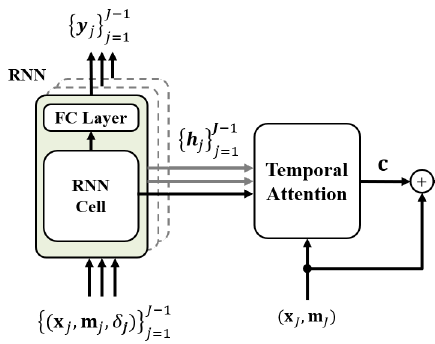



This consists of 1) an RNN structure that is responsible to handle the
longitudinal data and make predictions for the next measurements of
time-varying covariates. Formally, it takes a tuple of
$(\mathbf{x_j}, \mathbf{m_j}, \delta_j)$ and outputs
$(\mathbf{y_j}, \mathbf{h_j})$ for each time stamp *j*, where
$\mathbf{y_j}$ is the estimate of the time-varying covariates, i.e.
$\mathbf{x_{j+1}}$ and $\mathbf{h_j}$ is the hidden state at *j*.

The output from above is fed into the temporal attention mechanism that
decides which states in the history to pay attention to. It outputs a
context vector $\mathbf{c}=\sum_{j=1}^{J-1} a_{j} \mathbf{h}_{j}$,
which is essntially a weighted sum of hidden states, where the weights
are assigned via the importance coefficient $a_j$

#### **Cause-specific Subnetwork**

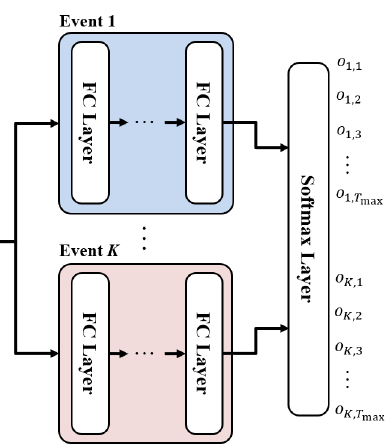
*Note: The images used in this section are borrowed from the paper (Lee, Yoon, & Schaar, 2020)*

Each cause-specific network *k* is a feed-forward network that takes the
context vector from the shared subnetwork and the last measurement
$(x_J, \mathbf{m_J})$ and outputs based on this information. The
context vector allows each cause-specific network to access important
information that has progressed through time from which it extracts the
underlying patterns that are distinct to each event. The resultant
vector $f_{c_k}(\mathbf{c}, x_J, \mathbf{m_J})$ is passed into the
output layer that employs a softmax layer to output an estimated joint
distribution of the first hitting times and competing events, which we
can utilize to estimate the CIF for a specific cause $k^{*}$ and
time $\tau^{*}$.



#### **Loss Functions**

The network is trained by minimising a sum of three independent loss
functions defined by
$\mathcal{L}_{\text {total }}=\mathcal{L}_{1}+\mathcal{L}_{2}+\mathcal{L}_{3}$.
The term $\mathcal{L}_1$ is a log-likelihood loss tailored for a
survival setting with history of longitudinal measurements and *K*
competing risks. $\mathcal{L}_2$ uses the estimated CIFs at the first
hitting times of events. It adapts the idea of concordance to penalize incorrect ranking of the subjects. The
loss compares a pair of subjects with different histories who have
experienced an event *k*, although at different times. Naturally, the
subject experiencing the event before should have a higher CIF at that
point. By virtue of this natural ranking, $\mathcal{L}_2$ enforces
correct orderings of pairs with respect to each event. In addition to
this, $\mathcal{L}_3$ is introduced as a prediction loss function for
time-varying covariates to regularize the shared subnetwork.

# **Experimental Design and Empirical Results**

We use a real-world dataset from International Financial Research (2020) containing observations
for 50,000 US mortgage borrowers. From these, 15,000 have defaulted. The
data is in longitudinal form going over 60 periods. Both left- and
right-censored loans are incorporated. We use covariates describing the
loan, customer and the macroeconomic environment. These include the TVCs
regarding the status of the loan at observation time as well as the
house price index, the interest rate, gross domestic product (GDP) and
the risk-free rate at observation time. Under continuous covariates, we
also have FICO score observed at the origin time of the load, which is
time-invariant. Apart from that, we have three binary variables that
offer us insights on: type of real estates (`REtype_CO_orig_time`);
whether the property belongs to an area with urban developments
(`REtype_SF_orig_time`); and whether the home is for a single family or
not (`REtype_SF_orig_time`).

Our empirical analysis is divided into three parts: the first part aims
to compare our model with Time-Varying Cox Model, which we use as a
benchmark; the second part of the analysis will analyse the importance
of time-varying nature of the TVC’s; the third part will focus on
analysing individual importance of each variable (we break the
correlation by permuting variables for each subject).

## **Data Organization**

All survival data should provide the follow information: 

1) First-hitting times of events, 

2) A d-dimensional covariate vector (for
each $i^{th}$ individual, where *i = 1, ..., n*) which could contain both
static and time-varying covariates, and 

3) Event labels, including
information on right-censoring.

We use this section to clean and preprocess the original DCR dataset. We also construct new variables by averaging the time-varying covariates for each subject. Further, we present an overview of the events and the distribution of the happening events with a Kaplan-Meier curve.

In [3]:
# reading the dcr dataset from http://www.internationalfinancialresearch.org/
data = pd.read_csv('dcr.csv') 

# sorting values by id and time
df = data.sort_values(by = ['id', 'time'])

# renumbering id values 
id_list = []
for i,_ in enumerate(pd.Series(df['id']).unique()):
    for x in range(sum(df['id'] == _)):
        id_list.append(i+1)
df['id_new'] = id_list

# constructing time-to-event variable
df.rename(columns = {'time': 'times'}, inplace = True)
df['tte'] = df.groupby('id')['times'].transform(max)
df['tte'] = df['tte']+1

# renaming variables 
df = df.drop(['id'], axis = 1)
df.rename(columns = {'id_new' : 'id', 'status_time' : 'label'}, inplace = True)

# taking averages of TVC's for each subject
cols_for_avg = ['balance_time', 'interest_rate_time', 'LTV_time', 'rate_time','hpi_time', 'gdp_time', 'uer_time']
for i in cols_for_avg:
    df['avg_'+i] = df.groupby('id')[i].transform(np.mean)


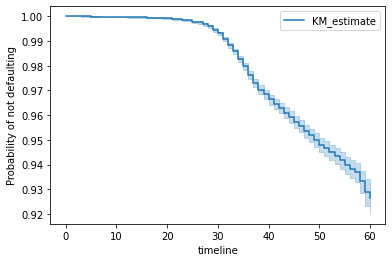

In [4]:
survival = KaplanMeierFitter() #
survival.fit(df['times'], df['default_time']) #Survival Curve for our dataset with default as event
survival.plot() #plot the Curve
plt.ylabel("Probability of not defaulting")
plt.show()

The Kaplan-Meier-Curve above shows the distribution of the probability of the selected event not occuring over time, here default. It typically has a falling shape, as with each additonal point in time the chance of defaulting becomes higher.

Below we visualize the distribution of the event payoff in the same fashion as above. Interestingly, the probability of a borrower paying off her loan decreases a bit less at around $t = 30$.

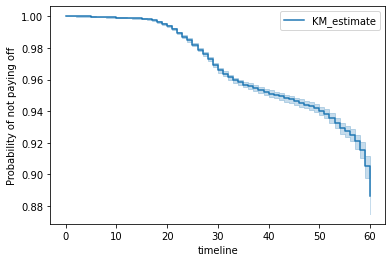

In [5]:
survival = KaplanMeierFitter() #
survival.fit(df['times'], df['payoff_time']) #Survival Curve for our dataset with payoff as event
survival.plot() #plot the Curve
plt.ylabel("Probability of not paying off")
plt.show()

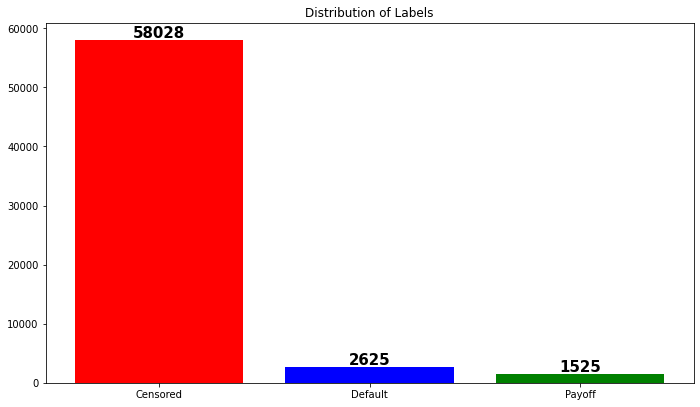

In [6]:
# DISTRIBUTION OF LABELS
counts_label = df['label'].value_counts()
fig = plt.figure(figsize=(9,5))
axes = fig.add_axes([0,0,1,1])
categ = ['Censored', 'Default', 'Payoff']
labels = [counts_label[0], counts_label[2], counts_label[1]]
axes.bar(categ, labels , color = ['red', 'blue', 'green'])
plt.title('Distribution of Labels')
for i in range(len(categ)):
    plt.text(i, labels[i]+400, labels[i], ha = 'center', fontweight = 'bold', fontsize = 15)
plt.show()

In [7]:
# SUBSETTING AND SAVING THE FINAL DATASET
cols = ['id', 'tte', 'times','label',
       'balance_time', 'LTV_time', 'interest_rate_time', 'rate_time',
       'hpi_time', 'gdp_time', 'uer_time','avg_balance_time', 'avg_interest_rate_time',
       'avg_LTV_time', 'avg_rate_time', 'avg_hpi_time', 'avg_gdp_time',
       'avg_uer_time','FICO_orig_time', 'REtype_CO_orig_time',
       'REtype_PU_orig_time', 'REtype_SF_orig_time', 'default_time', 'payoff_time']

df1 = df[cols]
df1.to_csv('dcr_cleaned.csv', index = False)

pd.read_csv('dcr_cleaned.csv').head()


,id,tte,times,label,balance_time,LTV_time,interest_rate_time,rate_time,hpi_time,gdp_time,uer_time,avg_balance_time,avg_interest_rate_time,avg_LTV_time,avg_rate_time,avg_hpi_time,avg_gdp_time,avg_uer_time,FICO_orig_time,REtype_CO_orig_time,REtype_PU_orig_time,REtype_SF_orig_time,default_time,payoff_time
0,1,61,25,0,61031.10,33.911009,10.500,5.9,226.29,2.899137,4.7,57546.403143,10.107143,41.626867,5.9,176.642286,1.264322,7.162857,587,0,0,1,0,0
1,1,61,26,0,60882.42,34.007232,10.500,5.9,225.10,2.151365,4.7,57546.403143,10.107143,41.626867,5.9,176.642286,1.264322,7.162857,587,0,0,1,0,0
2,1,61,27,0,60729.80,34.335349,10.500,5.9,222.39,2.361722,4.4,57546.403143,10.107143,41.626867,5.9,176.642286,1.264322,7.162857,587,0,0,1,0,0
3,1,61,28,0,60576.14,34.672545,10.875,5.9,219.67,1.229172,4.6,57546.403143,10.107143,41.626867,5.9,176.642286,1.264322,7.162857,587,0,0,1,0,0
4,1,61,29,0,60424.39,34.951639,10.875,5.9,217.37,1.692969,4.5,57546.403143,10.107143,41.626867,5.9,176.642286,1.264322,7.162857,587,0,0,1,0,0


## **Experiments with Time Variant Cox Model**


### Preparation

The Time Variant Cox Model requires the dataset to be in longitudinal form. Each observation needs to have a column declaring the starting time and an ending time of an observation. Each observation is therefore a timeframe with the column `start` being the starting time and `times` being the ending time for the rows of our dataset. 


In [8]:
### Create class Preparation with 5 methods: __init__, readdf, save, load, cleaning and splitdata
class Preparation:
  def __init__(self):# Dont use any additional attributes    
    self.df = None # Placeholders. Set varabels as none and then update a resut 
    self.X_train = None
    self.X_test = None
    self.y_train = None
    self.y_test  = None
    self.X_train = None
    self.X_val = None
    self.y_train = None
    self.y_val = None
    self.cols_standardize = ['id', 'tte', 'times','label',
       'balance_time', 'LTV_time', 'interest_rate_time', 'rate_time',
       'hpi_time', 'gdp_time', 'uer_time','avg_balance_time', 'avg_interest_rate_time',
       'avg_LTV_time', 'avg_rate_time', 'avg_hpi_time', 'avg_gdp_time',
       'avg_uer_time','FICO_orig_time', 'REtype_CO_orig_time',
       'REtype_PU_orig_time', 'REtype_SF_orig_time', 'default_time', 'payoff_time']
### Pre-processing:
  # Read data
  def readdf (self, sep=",", filename="dcr_cleaned.csv", cwd = os.getcwd()): # Method whith 3 def attributes: sep - separator, getcwd - path to your working directory
    file_name = cwd + "/" + filename # Get path of file
    data = pd.read_csv(file_name, sep= sep) # Read csv
    self.df = data # Save filtered dataset 
    return self.df # Print dataset
  # Clean data
  def cleaning (self, data,longformat=True,individual="id", stop="times", stopname="start"): 
    if longformat:# Bring data into long format (necessary for using the lifeline package's Cox’s time varying proportional hazard model) 
        data[stopname] = data.groupby(individual)[stop].shift(1)
        data[stopname] = data[stopname].fillna(0)
        self.df = data # Save filtered dataset
        return self.df # Print dataset
### Saving and load objects as binary mode
  def save (self, dataname, dataframe , cwd = os.getcwd()):# Saving and load objects as binary mode
    with open( cwd + '/' + dataname + '.pkl','wb') as path_name: # save df, 'wb' specifies 'write'
      pickle.dump(dataframe, path_name)  
  def load (self, dataname, cwd = os.getcwd()):# Saving and load objects as binary mode
    with open( cwd + '/' + dataname + '.pkl' ,'rb') as path_name:# load df, 'rb' specifies 'read'
      dataframe = pickle.load(path_name)
      return dataframe # Print dataset
### Split the data into 3 sets: train(80%) + test(20%)  
  def splitdata (self, Xvar, yvar, perc_test=0.2,  shuffle=False):# Method needs 5 arguments: X set with independent vars, y - set w. dependent vars, perc_test=percentage for test set) 
    self.X_train, self.X_test, self.y_train, self.y_test = sklearn.model_selection.train_test_split(Xvar, yvar, test_size=perc_test,random_state=1234,  shuffle=shuffle)# Split data not randomly to train 80% and test 20%
    print(len(self.X_train),  len(self.X_test)) # len - length

### Fitting and testing CTV

In [9]:
#Set global variables
result_c_index=[]#extract c-index
result_brier_score=[]#extract brier score
pred_time_cox=[21, 23, 25, 30]# set evaluation time
k_event=['default_time', 'payoff_time']#set events
var_list=['id', 'tte', 'times',
       'balance_time', 'LTV_time', 'interest_rate_time', 'rate_time',
       'hpi_time', 'gdp_time', 'uer_time','avg_balance_time', 'avg_interest_rate_time',
       'avg_LTV_time', 'avg_rate_time', 'avg_hpi_time', 'avg_gdp_time',
       'avg_uer_time','FICO_orig_time', 'REtype_CO_orig_time',
       'REtype_PU_orig_time', 'REtype_SF_orig_time']

In [10]:
def brier_score_ctv(Prediction, Time_survival, Death, Time):#define a function to calculate a brier score
    N = len(Prediction)
    y_true = ((Time_survival <= Time) * Death).astype(float)
    return np.mean((Prediction - y_true.values)**2)

In [11]:
for j in k_event:#loop over number evaluation times
  print('predicting ' + j)
  var_list.append(j)
  temp=Preparation()#define an obkect
  newdf = temp.readdf()#read aur dataframe
  df_to_use=temp.cleaning(temp.df)#clean our dataframe for Time Varying Cox model
  temp.splitdata(df_to_use.loc[:,df_to_use.columns != j], yvar=df_to_use[j])# split data into test and train set
  X_train=temp.X_train#set train df with tvcs
  y_train=temp.y_train#set train df with dependent variable
  df_full=X_train[['id', 'times',
       'balance_time', 'LTV_time', 'interest_rate_time', 'rate_time',
       'hpi_time', 'gdp_time', 'uer_time','FICO_orig_time',  'start']]
  df2=pd.concat([df_full,  y_train], axis=1)#merge df with dependent and independent variables
  df3=df2.dropna()#drop missing values
  for i in pred_time_cox:#loop over number of events
    print('summary for prediction time ' + str(i))
    X_test=temp.X_test#set test df with tvcs
    y_test=temp.y_test#set test df with dependent variable
    X_test=X_test[['id', 'times',
       'balance_time', 'LTV_time', 'interest_rate_time', 'rate_time',
       'hpi_time', 'gdp_time', 'uer_time','FICO_orig_time',  'start']]
    df2_test=pd.concat([X_test,  y_test], axis=1)#merge df with dependent and independent variables
    df2_testb=df2_test.loc[df2_test['times']<=i]#set restriction for evaluation (equal prediction time plus evaluation time)
    df3_test=df2_testb.dropna()#drop missing values
    ctv = CoxTimeVaryingFitter(penalizer=0.1)#implements fitting Cox’s time-varying proportional hazard model 
    ctv.fit(df3, id_col="id", event_col=j, start_col="start", stop_col="times", show_progress=True )
    ctv.print_summary() #summary of the fitted model with different values of the parametric partial hazard and Partial AIC
    pred=ctv.baseline_cumulative_hazard_['baseline hazard'][i] * ctv.predict_partial_hazard(df3_test)#predicting the probabilities
    res1=concordance_index(df3_test['times'], -pred, df3_test[j])# calculate a c-index
    res2=brier_score_ctv(pred, df3_test['times']  ,df3_test[j] , i)# calculate a brier score
    result_c_index.append(res1)
    result_brier_score.append(res2)

predicting default_time
49742 12436
summary for prediction time 21
Iteration 5: norm_delta = 0.00000, step_size = 1.00000, ll = -8844.91672, newton_decrement = 0.00000, seconds_since_start = 0.5Convergence completed after 5 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 49742 periods, 3920 subjects, 1210 events>
         event col = 'default_time'
         penalizer = 0.1
number of subjects = 3920
 number of periods = 49742
  number of events = 1210
partial log-likelihood = -8844.92
  time fit was run = 2021-08-31 21:38:44 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
balance_time        -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
LTV_time             0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
interest_rate_time   0.03       1.03       0.01             0.02             0.05                 1.02                 1.05
rate_time            0.07       1.07       0.03             0.02             0.12                 1.02                 1.12
hpi_time            -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
gdp_time             0.00       1.00       0.01            -0.01             0.02                 0.99                 1.02
uer_time             0.00       1.00       0.01            -0.01             0.02                 0.99                 1.02
FICO_orig_time      -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00

                       z      p   -log2(p)
covariate                                 
balance_time       -0.64   0.52       0.93
LTV_time            3.91 <0.005      13.42
interest_rate_time  5.31 <0.005      23.09
rate_time           2.66   0.01       6.98
hpi_time           -1.14   0.25       1.97
gdp_time            0.21   0.83       0.26
uer_time            0.22   0.83       0.28
FICO_orig_time     -5.94 <0.005      28.34
---
Partial AIC = 17705.83
log-likelihood ratio test = 96.56 on 8 df
-log2(p) of ll-ratio test = 55.37

summary for prediction time 23
Iteration 5: norm_delta = 0.00000, step_size = 1.00000, ll = -8844.91672, newton_decrement = 0.00000, seconds_since_start = 0.5Convergence completed after 5 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 49742 periods, 3920 subjects, 1210 events>
         event col = 'default_time'
         penalizer = 0.1
number of subjects = 3920
 number of periods = 49742
  number of events = 1210
partial log-likelihood = -8844.92
  time fit was run = 2021-08-31 21:38:44 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
balance_time        -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
LTV_time             0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
interest_rate_time   0.03       1.03       0.01             0.02             0.05                 1.02                 1.05
rate_time            0.07       1.07       0.03             0.02             0.12                 1.02                 1.12
hpi_time            -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
gdp_time             0.00       1.00       0.01            -0.01             0.02                 0.99                 1.02
uer_time             0.00       1.00       0.01            -0.01             0.02                 0.99                 1.02
FICO_orig_time      -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00

                       z      p   -log2(p)
covariate                                 
balance_time       -0.64   0.52       0.93
LTV_time            3.91 <0.005      13.42
interest_rate_time  5.31 <0.005      23.09
rate_time           2.66   0.01       6.98
hpi_time           -1.14   0.25       1.97
gdp_time            0.21   0.83       0.26
uer_time            0.22   0.83       0.28
FICO_orig_time     -5.94 <0.005      28.34
---
Partial AIC = 17705.83
log-likelihood ratio test = 96.56 on 8 df
-log2(p) of ll-ratio test = 55.37

summary for prediction time 25
Iteration 5: norm_delta = 0.00000, step_size = 1.00000, ll = -8844.91672, newton_decrement = 0.00000, seconds_since_start = 0.5Convergence completed after 5 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 49742 periods, 3920 subjects, 1210 events>
         event col = 'default_time'
         penalizer = 0.1
number of subjects = 3920
 number of periods = 49742
  number of events = 1210
partial log-likelihood = -8844.92
  time fit was run = 2021-08-31 21:38:45 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
balance_time        -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
LTV_time             0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
interest_rate_time   0.03       1.03       0.01             0.02             0.05                 1.02                 1.05
rate_time            0.07       1.07       0.03             0.02             0.12                 1.02                 1.12
hpi_time            -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
gdp_time             0.00       1.00       0.01            -0.01             0.02                 0.99                 1.02
uer_time             0.00       1.00       0.01            -0.01             0.02                 0.99                 1.02
FICO_orig_time      -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00

                       z      p   -log2(p)
covariate                                 
balance_time       -0.64   0.52       0.93
LTV_time            3.91 <0.005      13.42
interest_rate_time  5.31 <0.005      23.09
rate_time           2.66   0.01       6.98
hpi_time           -1.14   0.25       1.97
gdp_time            0.21   0.83       0.26
uer_time            0.22   0.83       0.28
FICO_orig_time     -5.94 <0.005      28.34
---
Partial AIC = 17705.83
log-likelihood ratio test = 96.56 on 8 df
-log2(p) of ll-ratio test = 55.37

summary for prediction time 30
Iteration 5: norm_delta = 0.00000, step_size = 1.00000, ll = -8844.91672, newton_decrement = 0.00000, seconds_since_start = 0.6Convergence completed after 5 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 49742 periods, 3920 subjects, 1210 events>
         event col = 'default_time'
         penalizer = 0.1
number of subjects = 3920
 number of periods = 49742
  number of events = 1210
partial log-likelihood = -8844.92
  time fit was run = 2021-08-31 21:38:46 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
balance_time        -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
LTV_time             0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
interest_rate_time   0.03       1.03       0.01             0.02             0.05                 1.02                 1.05
rate_time            0.07       1.07       0.03             0.02             0.12                 1.02                 1.12
hpi_time            -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
gdp_time             0.00       1.00       0.01            -0.01             0.02                 0.99                 1.02
uer_time             0.00       1.00       0.01            -0.01             0.02                 0.99                 1.02
FICO_orig_time      -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00

                       z      p   -log2(p)
covariate                                 
balance_time       -0.64   0.52       0.93
LTV_time            3.91 <0.005      13.42
interest_rate_time  5.31 <0.005      23.09
rate_time           2.66   0.01       6.98
hpi_time           -1.14   0.25       1.97
gdp_time            0.21   0.83       0.26
uer_time            0.22   0.83       0.28
FICO_orig_time     -5.94 <0.005      28.34
---
Partial AIC = 17705.83
log-likelihood ratio test = 96.56 on 8 df
-log2(p) of ll-ratio test = 55.37

predicting payoff_time
49742 12436
summary for prediction time 21
Iteration 5: norm_delta = 0.00000, step_size = 1.00000, ll = -16449.81476, newton_decrement = 0.00000, seconds_since_start = 0.5Convergence completed after 5 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 49742 periods, 3920 subjects, 2132 events>
         event col = 'payoff_time'
         penalizer = 0.1
number of subjects = 3920
 number of periods = 49742
  number of events = 2132
partial log-likelihood = -16449.81
  time fit was run = 2021-08-31 21:38:47 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
balance_time        -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
LTV_time            -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
interest_rate_time   0.02       1.02       0.01             0.00             0.03                 1.00                 1.03
rate_time           -0.11       0.89       0.02            -0.16            -0.07                 0.85                 0.93
hpi_time            -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
gdp_time             0.03       1.03       0.01             0.01             0.04                 1.01                 1.04
uer_time             0.01       1.01       0.01            -0.00             0.03                 1.00                 1.03
FICO_orig_time      -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00

                       z      p   -log2(p)
covariate                                 
balance_time       -2.62   0.01       6.83
LTV_time           -7.44 <0.005      43.16
interest_rate_time  2.78   0.01       7.50
rate_time          -4.96 <0.005      20.46
hpi_time           -4.84 <0.005      19.59
gdp_time            3.72 <0.005      12.30
uer_time            1.71   0.09       3.52
FICO_orig_time     -3.19 <0.005       9.45
---
Partial AIC = 32915.63
log-likelihood ratio test = 149.13 on 8 df
-log2(p) of ll-ratio test = 91.44

summary for prediction time 23
Iteration 5: norm_delta = 0.00000, step_size = 1.00000, ll = -16449.81476, newton_decrement = 0.00000, seconds_since_start = 0.5Convergence completed after 5 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 49742 periods, 3920 subjects, 2132 events>
         event col = 'payoff_time'
         penalizer = 0.1
number of subjects = 3920
 number of periods = 49742
  number of events = 2132
partial log-likelihood = -16449.81
  time fit was run = 2021-08-31 21:38:48 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
balance_time        -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
LTV_time            -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
interest_rate_time   0.02       1.02       0.01             0.00             0.03                 1.00                 1.03
rate_time           -0.11       0.89       0.02            -0.16            -0.07                 0.85                 0.93
hpi_time            -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
gdp_time             0.03       1.03       0.01             0.01             0.04                 1.01                 1.04
uer_time             0.01       1.01       0.01            -0.00             0.03                 1.00                 1.03
FICO_orig_time      -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00

                       z      p   -log2(p)
covariate                                 
balance_time       -2.62   0.01       6.83
LTV_time           -7.44 <0.005      43.16
interest_rate_time  2.78   0.01       7.50
rate_time          -4.96 <0.005      20.46
hpi_time           -4.84 <0.005      19.59
gdp_time            3.72 <0.005      12.30
uer_time            1.71   0.09       3.52
FICO_orig_time     -3.19 <0.005       9.45
---
Partial AIC = 32915.63
log-likelihood ratio test = 149.13 on 8 df
-log2(p) of ll-ratio test = 91.44

summary for prediction time 25
Iteration 5: norm_delta = 0.00000, step_size = 1.00000, ll = -16449.81476, newton_decrement = 0.00000, seconds_since_start = 0.5Convergence completed after 5 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 49742 periods, 3920 subjects, 2132 events>
         event col = 'payoff_time'
         penalizer = 0.1
number of subjects = 3920
 number of periods = 49742
  number of events = 2132
partial log-likelihood = -16449.81
  time fit was run = 2021-08-31 21:38:48 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
balance_time        -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
LTV_time            -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
interest_rate_time   0.02       1.02       0.01             0.00             0.03                 1.00                 1.03
rate_time           -0.11       0.89       0.02            -0.16            -0.07                 0.85                 0.93
hpi_time            -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
gdp_time             0.03       1.03       0.01             0.01             0.04                 1.01                 1.04
uer_time             0.01       1.01       0.01            -0.00             0.03                 1.00                 1.03
FICO_orig_time      -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00

                       z      p   -log2(p)
covariate                                 
balance_time       -2.62   0.01       6.83
LTV_time           -7.44 <0.005      43.16
interest_rate_time  2.78   0.01       7.50
rate_time          -4.96 <0.005      20.46
hpi_time           -4.84 <0.005      19.59
gdp_time            3.72 <0.005      12.30
uer_time            1.71   0.09       3.52
FICO_orig_time     -3.19 <0.005       9.45
---
Partial AIC = 32915.63
log-likelihood ratio test = 149.13 on 8 df
-log2(p) of ll-ratio test = 91.44

summary for prediction time 30
Iteration 5: norm_delta = 0.00000, step_size = 1.00000, ll = -16449.81476, newton_decrement = 0.00000, seconds_since_start = 0.5Convergence completed after 5 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 49742 periods, 3920 subjects, 2132 events>
         event col = 'payoff_time'
         penalizer = 0.1
number of subjects = 3920
 number of periods = 49742
  number of events = 2132
partial log-likelihood = -16449.81
  time fit was run = 2021-08-31 21:38:49 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
balance_time        -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
LTV_time            -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
interest_rate_time   0.02       1.02       0.01             0.00             0.03                 1.00                 1.03
rate_time           -0.11       0.89       0.02            -0.16            -0.07                 0.85                 0.93
hpi_time            -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
gdp_time             0.03       1.03       0.01             0.01             0.04                 1.01                 1.04
uer_time             0.01       1.01       0.01            -0.00             0.03                 1.00                 1.03
FICO_orig_time      -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00

                       z      p   -log2(p)
covariate                                 
balance_time       -2.62   0.01       6.83
LTV_time           -7.44 <0.005      43.16
interest_rate_time  2.78   0.01       7.50
rate_time          -4.96 <0.005      20.46
hpi_time           -4.84 <0.005      19.59
gdp_time            3.72 <0.005      12.30
uer_time            1.71   0.09       3.52
FICO_orig_time     -3.19 <0.005       9.45
---
Partial AIC = 32915.63
log-likelihood ratio test = 149.13 on 8 df
-log2(p) of ll-ratio test = 91.44

We test our CTV on different prediction times that we have selected. These are comprised of the median evaluation time for DDH addded by each pred_time value from DDH. This is because evaluation time is defined as the time elapsed since the prediciton time, i.e. $\Delta t$. Hence we add the values from DDH's pred_time to the median eval_time to receive a suitable set of prediction times for CTV. Since CTV works similar as Linear Regression, the coefficients can be used as an insight about variable's influence on the event analyzed.

When predicting a borrower's default, only the interest rate and the risk-free rate seem to have a positive affection greater than $1$, indifferent of the time-horizon used for predicton. The significance of the covariates stays constant during all times as well. Only Loan-to-Value ratio, the interest rate, the risk-free rate and the FICO score are significant, with the risk-free rate being only for a 10% level.

The coefficients stay also constant when predicting a borrower's payoff. Interest rate, GDP and unemployment rate affect the chance of paying off a loan by more than 1, while a rise in the risk-free rate by 1 % increases the chance of paying off a loan by only 0.89% c.p. This is interesting, as the estimate is also significant. All other covariates excluding the unemployment rate are significant as well, with the outstanding balance and interest rate are only significant for a 10% level.

These scores might suggest a change in feature selection for optimizing predictions. As this paper aims on evaluating the use of TVCs, we will nonetheless not alter the set of variables as this would result in a lower selection of TVCs.

## **Experiments with Dynamic-Deephit**

As part of the experiment, our main model (denoted as Model 1) includes the time-varying
covariates (GDP, unemployment rate, interest rate, risk-free rate,
loan-to-value ratio), a time-invariant covariate on FICO score, and all
the binary variables as described above. We report the dynamic C-index
on validation and test sets in the next section. 

For the second part of the experiment, we average the variables for each
subject and report the dynamic C-index with the same settings as Model 1 The idea is that if
time matters for our model, taking average values for each variable
should yield significantly worse evaluation metrics.

Below are a few user-defined functions for readying inputs for dynamic deephit:

In [12]:

def f_get_Normalization(X, norm_mode):    
    num_Patient, num_Feature = np.shape(X)
    
    if norm_mode == 'standard': #zero mean unit variance
        for j in range(num_Feature):
            if np.nanstd(X[:,j]) != 0:
                X[:,j] = (X[:,j] - np.nanmean(X[:, j]))/np.nanstd(X[:,j])
            else:
                X[:,j] = (X[:,j] - np.nanmean(X[:, j]))
    elif norm_mode == 'normal': #min-max normalization
        for j in range(num_Feature):
            X[:,j] = (X[:,j] - np.nanmin(X[:,j]))/(np.nanmax(X[:,j]) - np.nanmin(X[:,j]))
    else:
        print("INPUT MODE ERROR!")
    
    return X


def f_get_fc_mask1(meas_time, num_Event, num_Category):
    '''
        mask1 is required to get the contional probability (to calculate the denominator part)
        mask1 size is [N, num_Event, num_Category]. 1's until the last measurement time
    '''
    mask1 = np.zeros([np.shape(meas_time)[0], num_Event, num_Category]) # for denominator
    for i in range(np.shape(meas_time)[0]):
        mask1[i, :, :int(meas_time[i, 0]+1)] = 1 # last measurement time

    return mask1


def f_get_fc_mask2(time, label, num_Event, num_Category):
    '''
        mask2 is required to get the log-likelihood loss 
        mask2 size is [N, num_Event, num_Category]
            if not censored : one element = 1 (0 elsewhere)
            if censored     : fill elements with 1 after the censoring time (for all events)
    '''
    mask2 = np.zeros([np.shape(time)[0], num_Event, num_Category]) # for the first loss function
    for i in range(np.shape(time)[0]):
        if label[i,0] != 0:  #not censored
            mask2[i,int(label[i,0]-1),int(time[i,0])] = 1
        else: #label[i,2]==0: censored
            mask2[i,:,int(time[i,0]+1):] =  1 #fill 1 until from the censoring time (to get 1 - \sum F)
    return mask2


def f_get_fc_mask3(time, pat_info, num_Category):
    '''
        mask3 is required calculate the ranking loss (for pair-wise comparision)
        mask3 size is [N, num_Category]. 
        - For longitudinal measurements:
             1's from the last measurement to the event time (exclusive and inclusive, respectively)
             denom is not needed since comparing is done over the same denom
        - For single measurement:
             1's from start to the event time(inclusive)
    '''
    #mask = np.zeros([np.shape(time)[0], num_Category]) # for the first loss function
    #if np.shape(meas_time):  #lonogitudinal measurements 
    #    for i in range(np.shape(time)[0]):
    #        t1 = int(meas_time[i, 0]) # last measurement time
    #        t2 = int(time[i, 0]) # censoring/event time
    #        mask[i,(t1+1):(t2+1)] = 1  #this excludes the last measurement time and includes the event time
    #else:                    #single measurement
    #    for i in range(np.shape(time)[0]):
    #        t = int(time[i, 0]) # censoring/event time
    #        mask[i,:(t+1)] = 1  #this excludes the last measurement time and includes the event time
   
    mask3 = np.zeros([np.shape(time)[0], num_Category])
    for i in range(np.shape(time)[0]):
        if pat_info[i,4] >1:
            t1 = int(pat_info[i,3]) #last measurement time
            t2 = int(pat_info[i,1]) #tte
            mask3[i,(t1+1):(t2+1)] = 1
        else:
            t = int(pat_info[i,1])
            mask3[i, :(t+1)] = 1
    return mask3




# TRANSFORMING DATA
def f_construct_dataset(df, feat_list):
    '''
        id   : patient indicator
        tte  : time-to-event or time-to-censoring
            - must be synchronized based on the reference time
        times: time at which observations are measured
            - must be synchronized based on the reference time (i.e., times start from 0)
        label: event/censoring information
            - 0: censoring
            - 1: event type 1
            - 2: event type 2
            ...
    '''

    grouped  = df.groupby(['id'])
    id_list  = pd.unique(df['id'])
    max_meas = np.max(grouped.count())[0]

    data     = np.zeros([len(id_list), max_meas, len(feat_list)+1])
    pat_info = np.zeros([len(id_list), 5])

    for i, tmp_id in enumerate(id_list):
        tmp = grouped.get_group(tmp_id).reset_index(drop=True)

        pat_info[i,4] = tmp.shape[0]             #number of measurements for each subject
        pat_info[i,3] = np.max(tmp['times'])     #last measurement time
        pat_info[i,2] = tmp['label'][0]      #type of event
        pat_info[i,1] = tmp['tte'][0]         #time-to-event
        pat_info[i,0] = tmp['id'][0]      

        data[i, :int(pat_info[i, 4]), 1:]  = tmp[feat_list]
        data[i, :int(pat_info[i, 4]-1), 0] = np.diff(tmp['times'])
    
    return pat_info, data


def import_dataset( data, bin_list, cont_list, norm_mode = 'standard'):

    df_                = pd.read_csv(data)

    feat_list          = cont_list + bin_list
    df_                = df_[['id', 'tte', 'times', 'label']+feat_list]
    df_org_            = df_.copy(deep=True)

    df_[cont_list]     = f_get_Normalization(np.asarray(df_[cont_list]).astype(float), norm_mode)

    pat_info, data     = f_construct_dataset(df_, feat_list)
    _, data_org        = f_construct_dataset(df_org_, feat_list)

    data_mi                  = np.zeros(np.shape(data))
    data_mi[np.isnan(data)]  = 1
    data_org[np.isnan(data)] = 0
    data[np.isnan(data)]     = 0 

    x_dim           = np.shape(data)[2] # 1 + x_dim_cont + x_dim_bin (including delta)
    x_dim_cont      = len(cont_list)
    x_dim_bin       = len(bin_list) 

    last_meas       = pat_info[:,[3]]  #pat_info[:, 3] contains the last measurement time
    label           = pat_info[:,[2]]  #label for two competing risks (default 1 and payoff 2)
    time            = pat_info[:,[1]]  #time when event occurred

    num_Category    = int(np.max(pat_info[:, 1]) * 1.2) 
    num_Event       = len(np.unique(label)) - 1

    if num_Event == 1:
        label[np.where(label!=0)] = 1 #make single risk

    mask1           = f_get_fc_mask1(last_meas, num_Event, num_Category)
    mask2           = f_get_fc_mask2(time, label, num_Event, num_Category)
    mask3           = f_get_fc_mask3(time, pat_info, num_Category)

    DIM             = (x_dim, x_dim_cont, x_dim_bin)
    DATA            = (data, time, label)
    MASK            = (mask1, mask2, mask3)

    return DIM, DATA, MASK, data_mi #returns dimensions of inputs, information of the subject, mask vectors to inidicate missing values

Next, we borrow the prediction functions in the original Dynamic DeepHit code on GitHub.

In [13]:
def _f_get_pred(sess, model, data, data_mi, pred_horizon):
    '''
        predictions based on the prediction time.
        create new_data and new_mask2 that are available previous or equal to the prediction time (no future measurements are used)
    '''
    new_data    = np.zeros(np.shape(data))
    new_data_mi = np.zeros(np.shape(data_mi))

    meas_time = np.concatenate([np.zeros([np.shape(data)[0], 1]), np.cumsum(data[:, :, 0], axis=1)[:, :-1]], axis=1)

    for i in range(np.shape(data)[0]):
        last_meas = np.sum(meas_time[i, :] <= pred_horizon)

        new_data[i, :last_meas, :]    = data[i, :last_meas, :]
        new_data_mi[i, :last_meas, :] = data_mi[i, :last_meas, :]

    return model.predict(new_data, new_data_mi)


def f_get_risk_predictions(sess, model, data_, data_mi_, pred_time, eval_time):
    
    pred = _f_get_pred(sess, model, data_[[0]], data_mi_[[0]], 0)
    _, num_Event, num_Category = np.shape(pred)
       
    risk_all = {}
    for k in range(num_Event):
        risk_all[k] = np.zeros([np.shape(data_)[0], len(pred_time), len(eval_time)])
            
    for p, p_time in enumerate(pred_time):
        ### PREDICTION
        pred_horizon = int(p_time)
        pred = _f_get_pred(sess, model, data_, data_mi_, pred_horizon)


        for t, t_time in enumerate(eval_time):
            eval_horizon = int(t_time) + pred_horizon #if eval_horizon >= num_Category, output the maximum...

            # calculate F(t | x, Y, t >= t_M) = \sum_{t_M <= \tau < t} P(\tau | x, Y, \tau > t_M)
            risk = np.sum(pred[:,:,pred_horizon:(eval_horizon+1)], axis=2) #risk score until eval_time
            risk = risk / (np.sum(np.sum(pred[:,:,pred_horizon:], axis=2), axis=1, keepdims=True) +_EPSILON) #conditioniong on t > t_pred
            
            for k in range(num_Event):
                risk_all[k][:, p, t] = risk[:, k]
                
    return risk_all

## **Model 1**

This model uses all the time-varying covariates, normalized with zero mean and unit variance

#### **Preparing data for DDH**

In [14]:
data_mode                   = 'DCR' 
seed = 1234
##### IMPORT DATASET
'''
    num_Category            = max event/censoring time * 1.2
    num_Event               = number of evetns i.e. len(np.unique(label))-1
    max_length              = maximum number of measurements
    x_dim                   = data dimension including delta (1 + num_features)
    x_dim_cont              = dim of continuous features
    x_dim_bin               = dim of binary features
    mask1, mask2, mask3     = used for cause-specific network (FCNet structure)
'''

if data_mode == 'DCR':
    (x_dim, x_dim_cont, x_dim_bin), (data, time, label), (mask1, mask2, mask3), (data_mi) = import_dataset(norm_mode = 'standard', data = 'dcr_cleaned.csv', bin_list = ['REtype_CO_orig_time', 'REtype_PU_orig_time', 'REtype_SF_orig_time'],
                                                                                                                cont_list = ['balance_time', 'LTV_time', 'interest_rate_time', 'rate_time', 'hpi_time', 'FICO_orig_time', 'uer_time', 'gdp_time'])
    
    # This must be changed depending on the datasets, prediction/evaliation times of interest
    pred_time = [12, 20, 30] # prediction time (in months)
    eval_time = [1, 3, 5, 10] # months evaluation time (for C-index and Brier-Score)
else:
    print ('ERROR:  DATA_MODE NOT FOUND !!!')

_, num_Event, num_Category  = np.shape(mask1)  # dim of mask3: [subj, Num_Event, Num_Category]
max_length                  = np.shape(data)[1]


file_path = '{}'.format(data_mode)

if not os.path.exists(file_path):
    os.makedirs(file_path)

#### **Setting Hyperparameters**

In [15]:
burn_in_mode                = 'ON' #{'ON', 'OFF'}
boost_mode                  = 'ON' #{'ON', 'OFF'}


new_parser = {'mb_size': 32, 'iteration_burn_in': 2000, 'iteration': 10000, 'keep_prob': 0.6, 'lr_train': 1e-4,'h_dim_RNN': 100, 'h_dim_FC' : 100, 'num_layers_RNN':2,'num_layers_ATT':2,'num_layers_CS' :2,
              'RNN_type':'LSTM', 'FC_active_fn' : tf.nn.relu, 'RNN_active_fn': tf.nn.tanh, 'reg_W': 1e-5, 'reg_W_out'     : 0., 'alpha' :1.0, 'beta'  :0.1,'gamma' :1.0}

# INPUT DIMENSIONS
input_dims                  = { 'x_dim': x_dim, 'x_dim_cont': x_dim_cont, 'x_dim_bin': x_dim_bin, 'num_Event': num_Event, 'num_Category': num_Category,  'max_length' : max_length }

# NETWORK HYPER-PARMETERS
network_settings            = { 'h_dim_RNN': new_parser['h_dim_RNN'], 'h_dim_FC': new_parser['h_dim_FC'], 'num_layers_RNN'    : new_parser['num_layers_RNN'], 'num_layers_ATT' : new_parser['num_layers_ATT'], 'num_layers_CS': new_parser['num_layers_CS'], 
                               'RNN_type': new_parser['RNN_type'], 'FC_active_fn': new_parser['FC_active_fn'], 'RNN_active_fn':new_parser['RNN_active_fn'], 'initial_W': tf.contrib.layers.xavier_initializer(), 'reg_W': new_parser['reg_W'], 
                               'reg_W_out': new_parser['reg_W_out']}


mb_size           = new_parser['mb_size']
iteration         = new_parser['iteration']
iteration_burn_in = new_parser['iteration_burn_in']

keep_prob         = new_parser['keep_prob']
lr_train          = new_parser['lr_train']

alpha             = new_parser['alpha']
beta              = new_parser['beta']
gamma             = new_parser['gamma']

# SAVE HYPERPARAMETERS
log_name = file_path + '/hyperparameters_log.txt'
save_logging(new_parser, log_name)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



#### **Defining training, validation and test sets**

We split the data in two parts, setting aside 20 percent of the observations for the test set. We further split the remaining dataset into training (80 percent) and validation (20 percent) sets. 


In [16]:
(tr_data,te_data, tr_data_mi, te_data_mi, tr_time,te_time, tr_label,te_label, 
 tr_mask1,te_mask1, tr_mask2,te_mask2, tr_mask3,te_mask3) = train_test_split(data, data_mi, time, label, mask1, mask2, mask3, test_size=0.2, random_state=seed) 

(tr_data,va_data, tr_data_mi, va_data_mi, tr_time,va_time, tr_label,va_label, 
 tr_mask1,va_mask1, tr_mask2,va_mask2, tr_mask3,va_mask3) = train_test_split(tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3, test_size=0.2, random_state=seed) 

if boost_mode == 'ON':
    tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3 = f_get_boosted_trainset(tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3)

#### **Training DDH**

In [ ]:
_EPSILON = 1e-08

tf.reset_default_graph()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

model = Model_Longitudinal_Attention(sess, "Dyanmic-DeepHit", input_dims, network_settings)
saver = tf.train.Saver()

sess.run(tf.global_variables_initializer())

 
### TRAINING - BURN-IN
if burn_in_mode == 'ON':
    print( "BURN-IN TRAINING ...")
    for itr in range(iteration_burn_in):
        x_mb, x_mi_mb, k_mb, t_mb, m1_mb, m2_mb, m3_mb = f_get_minibatch(mb_size, tr_data, tr_data_mi, tr_label, tr_time, tr_mask1, tr_mask2, tr_mask3)
        DATA = (x_mb, k_mb, t_mb)
        MISSING = (x_mi_mb)

        _, loss_curr = model.train_burn_in(DATA, MISSING, keep_prob, lr_train)

        if (itr+1)%1000 == 0:
            print('itr: {:04d} | loss: {:.4f}'.format(itr+1, loss_curr))


### TRAINING - MAIN
print( "MAIN TRAINING ...")
min_valid = 0.5

for itr in range(iteration):
    x_mb, x_mi_mb, k_mb, t_mb, m1_mb, m2_mb, m3_mb = f_get_minibatch(mb_size, tr_data, tr_data_mi, tr_label, tr_time, tr_mask1, tr_mask2, tr_mask3)
    DATA = (x_mb, k_mb, t_mb)
    MASK = (m1_mb, m2_mb, m3_mb)
    MISSING = (x_mi_mb)
    PARAMETERS = (alpha, beta, gamma)

    _, loss_curr = model.train(DATA, MASK, MISSING, PARAMETERS, keep_prob, lr_train)

    if (itr+1)%1000 == 0:
        print('itr: {:04d} | loss: {:.4f}'.format(itr+1, loss_curr))

    ### VALIDATION  (based on average C-index of our interest)
    if (itr+1)%1000 == 0:        
        risk_all = f_get_risk_predictions(sess, model, va_data, va_data_mi, pred_time, eval_time)
        
        for p, p_time in enumerate(pred_time):
            pred_horizon = int(p_time)
            val_result1 = np.zeros([num_Event, len(eval_time)])
            
            for t, t_time in enumerate(eval_time):                
                eval_horizon = int(t_time) + pred_horizon
                for k in range(num_Event):
                    val_result1[k, t] = c_index(risk_all[k][:, p, t], va_time, (va_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            
            if p == 0:
                val_final1 = val_result1
            else:
                val_final1 = np.append(val_final1, val_result1, axis=0)

        tmp_valid = np.mean(val_final1)

        if tmp_valid >  min_valid:
            min_valid_tvc = tmp_valid
            saver.save(sess, file_path + '/model')
            print( 'updated.... average c-index = ' + str('%.4f' %(tmp_valid)))

INFO:tensorflow:Scale of 0 disables regularizer.


Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.

Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.






BURN-IN TRAINING ...
itr: 1000 | loss: 5.0383
itr: 2000 | loss: 2.5224
MAIN TRAINING ...
itr: 1000 | loss: 2.1907
updated.... av

#### **Test DDH**

In [ ]:
saver.restore(sess, file_path + '/model')

risk_all = f_get_risk_predictions(sess, model, te_data, te_data_mi, pred_time, eval_time)

for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t], te_time, (te_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t], te_time, (te_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
    
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
        
row_header = []
for p_time in pred_time:
    for t in range(num_Event):
        row_header.append('pred_time {}: event_{}'.format(p_time,t+1))
            
col_header = []
for t_time in eval_time:
    col_header.append('eval_time {}'.format(t_time))

# c-index result
df4 = pd.DataFrame(final1, index = row_header, columns=col_header)

# brier-score result
df5 = pd.DataFrame(final2, index = row_header, columns=col_header)

### PRINT RESULTS
print('========================================================')
print('--------------------------------------------------------')
print('- C-INDEX: ')
print(df4)
print('--------------------------------------------------------')
print('- BRIER-SCORE: ')
print(df5)
print('========================================================')

In [ ]:
res_ddh_c1=[df4.mean(axis=1)[[0,2,4]].mean(),df4.mean(axis=1)[[1,3,5]].mean()]
res_ddh_c1

In [ ]:
res_ddh_b1=[df5.mean(axis=1)[[0,2,4]].mean(),df5.mean(axis=1)[[1,3,5]].mean()]
res_ddh_b1

## **Empirical Results and Performance Evaluation**

In order to discriminate between our models, we employ a time-dependent
Concordance Index (C-index), which is an index used to evaluate
performance at different time horizons after issuing risk predictions.
We would like to recall C-index, which is essentially a ranking score:
for two subjects *i*, *j* who experience the same event, the model should
assign greater risk to i, given that it experiences the event before *j*. We employ a cause-specific time-dependent concordance index that the pioneers of Dynamic DeepHit themselves used, which extends the idea of time-dependent C-index to multiple risks and longitudinal measurements: $$C_{k}(t, \Delta t)=P\left(\hat{F}_{k}\left(t+\Delta t \mid \mathcal{X}^{i}(t)\right)>\hat{F}_{k}\left(t+\Delta t \mid \mathcal{X}^{j}(t)\right) \mid \tau^{i}<\tau^{j}, k^{i}=k, \tau^{i}<t+\Delta t\right)$$

The reader can read the formulas as follows: compute the probability that the estimated risk of experiencing event *k* for subject *i* at time $t + \Delta T$ is greater than the estimated risk for subject *j* at time $t + \Delta T$, given subject *i* experiences the event before subject *j* does. Therefore, higher concordance index implies better ranking and, by extension, higher accuracy. A value close to 1 will imply nearly perfect ordering of the subjects in the study. 



### **Inter-Model Comparison**

We compare DDH with CTV by using two indeces: Concordance-Index and Brier Score. While we used different prediction times for CTV, we use different evaluation times for DDH in addition. Evaluation time is the time elapsed since the prediciton time, i.e. $\Delta t$. By using averages for each score and event, we can compare the performance between the two models.

In [ ]:
df_to_print=pd.DataFrame({'Event': k_event*4, 'Time': np.repeat(pred_time_cox, 2 ), 'C-index CPH': result_c_index,'Brier score CPH': result_brier_score })# Prepare a table with results
df_to_print.to_excel('df_res.xlsx')# Export table with results
df_to_print

In [ ]:
df_to_print2=df_to_print.groupby('Event').mean()
df_to_print2['C-index DDH']=res_ddh_c1
df_to_print2['Brier score DDH']=res_ddh_b1
df_to_print2.to_excel('df_res2.xlsx')# Export table with results
df_to_print2

The table above presents the average scores for C-Index and Brier Score for both events and both models. DDH scores a higher C-Index as well as a lower Brier Score for each event under study, highlighting the predictive superiority of DDH. We would especially like to highlight the C-Index achieved by DDH, which surpasses a score of 0.99. This benchmark is unlikely to be beaten by any other model.

Scores for defaults are better for all models, which should result from the selection of variables being more targeted towards default than payoff. This is especially visible when expecting Brier Scores, which supports the assumption of variable selection being the cause for this phenomenon. This is because the C-Index is designed to measure the correct order of subjects, but not how well they are estimated, which is done by the Brier Score in summing the squared difference of the risk-prediction from the true target value.

### **Intra-Model Comparison**

Next, we test how the model performs when we take averages of each time-varying covariate one by one. We report the last reported validation scores for each model and compute the difference between them and the last reported validation score for the original model (Model 1). 

For consistent comparison, we assign the same seed and run the algorithm on the same slice of the dataset. 


##### **Model 2**

This model takes the average of loan balances for each subject across time while other variables remain unchanged

In [ ]:


data_mode                   = 'DCR' 
seed                        = 1234

##### IMPORT DATASET
'''
    num_Category            = max event/censoring time * 1.2
    num_Event               = number of evetns i.e. len(np.unique(label))-1
    max_length              = maximum number of measurements
    x_dim                   = data dimension including delta (1 + num_features)
    x_dim_cont              = dim of continuous features
    x_dim_bin               = dim of binary features
    mask1, mask2, mask3     = used for cause-specific network (FCNet structure)
'''

if data_mode == 'DCR':
    (x_dim, x_dim_cont, x_dim_bin), (data, time, label), (mask1, mask2, mask3), (data_mi) = import_dataset(norm_mode = 'standard', data = 'dcr_cleaned.csv', bin_list = ['REtype_CO_orig_time', 'REtype_PU_orig_time', 'REtype_SF_orig_time'],
                                                                                                                cont_list = ['avg_balance_time', 'LTV_time', 'interest_rate_time', 'rate_time', 'hpi_time', 'gdp_time', 'uer_time', 'FICO_orig_time'])
    
    # This must be changed depending on the datasets, prediction/evaliation times of interest
    pred_time = [12, 20, 30] # prediction time (in months)
    eval_time = [1, 3, 5, 10] # months evaluation time (for C-index and Brier-Score)
else:
    print ('ERROR:  DATA_MODE NOT FOUND !!!')

_, num_Event, num_Category  = np.shape(mask1)  # dim of mask3: [subj, Num_Event, Num_Category]
max_length                  = np.shape(data)[1]


file_path = '{}'.format(data_mode)

if not os.path.exists(file_path):
    os.makedirs(file_path)


burn_in_mode                = 'ON' #{'ON', 'OFF'}
boost_mode                  = 'ON' #{'ON', 'OFF'}

##### HYPER-PARAMETERS
new_parser = {'mb_size': 32, 'iteration_burn_in': 2000, 'iteration': 10000, 'keep_prob': 0.6, 'lr_train': 1e-4,'h_dim_RNN': 100, 'h_dim_FC' : 100, 'num_layers_RNN':2,'num_layers_ATT':2,'num_layers_CS' :2,
              'RNN_type':'LSTM', 'FC_active_fn' : tf.nn.relu, 'RNN_active_fn': tf.nn.tanh, 'reg_W': 1e-5, 'reg_W_out'     : 0., 'alpha' :1.0, 'beta'  :0.1,'gamma' :1.0}


# INPUT DIMENSIONS
input_dims                  = { 'x_dim': x_dim, 'x_dim_cont'    : x_dim_cont, 'x_dim_bin'     : x_dim_bin, 'num_Event'     : num_Event, 'num_Category'  : num_Category,  'max_length'    : max_length }

# NETWORK HYPER-PARMETERS
network_settings            = { 'h_dim_RNN'         : new_parser['h_dim_RNN'], 'h_dim_FC': new_parser['h_dim_FC'], 'num_layers_RNN'    : new_parser['num_layers_RNN'], 'num_layers_ATT'    : new_parser['num_layers_ATT'],
'num_layers_CS'     : new_parser['num_layers_CS'],
'RNN_type'          : new_parser['RNN_type'], 'FC_active_fn'      : new_parser['FC_active_fn'], 'RNN_active_fn'     : new_parser['RNN_active_fn'],
'initial_W'         : tf.contrib.layers.xavier_initializer(), 'reg_W'             : new_parser['reg_W'], 'reg_W_out'         : new_parser['reg_W_out']}


mb_size           = new_parser['mb_size']
iteration         = new_parser['iteration']
iteration_burn_in = new_parser['iteration_burn_in']

keep_prob         = new_parser['keep_prob']
lr_train          = new_parser['lr_train']

alpha             = new_parser['alpha']
beta              = new_parser['beta']
gamma             = new_parser['gamma']

# SAVE HYPERPARAMETERS
log_name = file_path + '/hyperparameters_log.txt'
save_logging(new_parser, log_name)


### TRAINING-TESTING SPLIT
(tr_data,te_data, tr_data_mi, te_data_mi, tr_time,te_time, tr_label,te_label, 
 tr_mask1,te_mask1, tr_mask2,te_mask2, tr_mask3,te_mask3) = train_test_split(data, data_mi, time, label, mask1, mask2, mask3, test_size=0.2, random_state=seed) 

(tr_data,va_data, tr_data_mi, va_data_mi, tr_time,va_time, tr_label,va_label, 
 tr_mask1,va_mask1, tr_mask2,va_mask2, tr_mask3,va_mask3) = train_test_split(tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3, test_size=0.2, random_state=seed) 

if boost_mode == 'ON':
    tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3 = f_get_boosted_trainset(tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3)



_EPSILON = 1e-08

tf.reset_default_graph()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

model = Model_Longitudinal_Attention(sess, "Dyanmic-DeepHit", input_dims, network_settings)
saver = tf.train.Saver()

sess.run(tf.global_variables_initializer())

 
### TRAINING - BURN-IN
if burn_in_mode == 'ON':
    print( "BURN-IN TRAINING ...")
    for itr in range(iteration_burn_in):
        x_mb, x_mi_mb, k_mb, t_mb, m1_mb, m2_mb, m3_mb = f_get_minibatch(mb_size, tr_data, tr_data_mi, tr_label, tr_time, tr_mask1, tr_mask2, tr_mask3)
        DATA = (x_mb, k_mb, t_mb)
        MISSING = (x_mi_mb)

        _, loss_curr = model.train_burn_in(DATA, MISSING, keep_prob, lr_train)

        if (itr+1)%1000 == 0:
            print('itr: {:04d} | loss: {:.4f}'.format(itr+1, loss_curr))


### TRAINING - MAIN
print( "MAIN TRAINING ...")
min_valid = 0.5

for itr in range(iteration):
    x_mb, x_mi_mb, k_mb, t_mb, m1_mb, m2_mb, m3_mb = f_get_minibatch(mb_size, tr_data, tr_data_mi, tr_label, tr_time, tr_mask1, tr_mask2, tr_mask3)
    DATA = (x_mb, k_mb, t_mb)
    MASK = (m1_mb, m2_mb, m3_mb)
    MISSING = (x_mi_mb)
    PARAMETERS = (alpha, beta, gamma)

    _, loss_curr = model.train(DATA, MASK, MISSING, PARAMETERS, keep_prob, lr_train)

    if (itr+1)%1000 == 0:
        print('itr: {:04d} | loss: {:.4f}'.format(itr+1, loss_curr))

    ### VALIDATION  (based on average C-index of our interest)
    if (itr+1)%1000 == 0:        
        risk_all = f_get_risk_predictions(sess, model, va_data, va_data_mi, pred_time, eval_time)
        
        for p, p_time in enumerate(pred_time):
            pred_horizon = int(p_time)
            val_result1 = np.zeros([num_Event, len(eval_time)])
            
            for t, t_time in enumerate(eval_time):                
                eval_horizon = int(t_time) + pred_horizon
                for k in range(num_Event):
                    val_result1[k, t] = c_index(risk_all[k][:, p, t], va_time, (va_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            
            if p == 0:
                val_final1_avgbalance = val_result1
            else:
                val_final1_avgbalance = np.append(val_final1_avgbalance, val_result1, axis=0)

        tmp_valid_avgbalance = np.mean(val_final1_avgbalance)

        if tmp_valid_avgbalance >  min_valid:
            min_valid_avgbalance = tmp_valid_avgbalance
            saver.save(sess, file_path + '/model')
            print( 'updated.... average c-index = ' + str('%.4f' %(tmp_valid_avgbalance)))



##### **Model 3**

This model takes the average of loan-to-value variable for each subject across time while other variables remain unchanged

In [ ]:

data_mode                   = 'DCR' 
seed                        = 1234

##### IMPORT DATASET
'''
    num_Category            = max event/censoring time * 1.2
    num_Event               = number of evetns i.e. len(np.unique(label))-1
    max_length              = maximum number of measurements
    x_dim                   = data dimension including delta (1 + num_features)
    x_dim_cont              = dim of continuous features
    x_dim_bin               = dim of binary features
    mask1, mask2, mask3     = used for cause-specific network (FCNet structure)
'''

if data_mode == 'DCR':
    (x_dim, x_dim_cont, x_dim_bin), (data, time, label), (mask1, mask2, mask3), (data_mi) = import_dataset(norm_mode = 'standard', data = 'dcr_cleaned.csv', bin_list = ['REtype_CO_orig_time', 'REtype_PU_orig_time', 'REtype_SF_orig_time'],
                                                                                                                cont_list = ['balance_time', 'avg_LTV_time', 'interest_rate_time', 'rate_time', 'hpi_time', 'gdp_time', 'uer_time', 'FICO_orig_time'])
    
    # This must be changed depending on the datasets, prediction/evaliation times of interest
    pred_time = [12, 20, 30] # prediction time (in months)
    eval_time = [1, 3, 5, 10] # months evaluation time (for C-index and Brier-Score)
else:
    print ('ERROR:  DATA_MODE NOT FOUND !!!')

_, num_Event, num_Category  = np.shape(mask1)  # dim of mask3: [subj, Num_Event, Num_Category]
max_length                  = np.shape(data)[1]


file_path = '{}'.format(data_mode)

if not os.path.exists(file_path):
    os.makedirs(file_path)

##### HYPER-PARAMETERS
burn_in_mode                = 'ON' #{'ON', 'OFF'}
boost_mode                  = 'ON' #{'ON', 'OFF'}

new_parser = {'mb_size': 32, 'iteration_burn_in': 2000, 'iteration': 10000, 'keep_prob': 0.6, 'lr_train': 1e-4,'h_dim_RNN': 100, 'h_dim_FC' : 100, 'num_layers_RNN':2,'num_layers_ATT':2,'num_layers_CS' :2,
              'RNN_type':'LSTM', 'FC_active_fn' : tf.nn.relu, 'RNN_active_fn': tf.nn.tanh, 'reg_W': 1e-5, 'reg_W_out'     : 0., 'alpha' :1.0, 'beta'  :0.1,'gamma' :1.0}


# INPUT DIMENSIONS
input_dims                  = { 'x_dim': x_dim, 'x_dim_cont'    : x_dim_cont, 'x_dim_bin'     : x_dim_bin, 'num_Event'     : num_Event, 'num_Category'  : num_Category,  'max_length'    : max_length }

# NETWORK HYPER-PARMETERS
network_settings            = { 'h_dim_RNN'         : new_parser['h_dim_RNN'], 'h_dim_FC': new_parser['h_dim_FC'], 'num_layers_RNN'    : new_parser['num_layers_RNN'], 'num_layers_ATT'    : new_parser['num_layers_ATT'],
'num_layers_CS'     : new_parser['num_layers_CS'],
'RNN_type'          : new_parser['RNN_type'], 'FC_active_fn'      : new_parser['FC_active_fn'], 'RNN_active_fn'     : new_parser['RNN_active_fn'],
'initial_W'         : tf.contrib.layers.xavier_initializer(), 'reg_W'             : new_parser['reg_W'], 'reg_W_out'         : new_parser['reg_W_out']}


mb_size           = new_parser['mb_size']
iteration         = new_parser['iteration']
iteration_burn_in = new_parser['iteration_burn_in']

keep_prob         = new_parser['keep_prob']
lr_train          = new_parser['lr_train']

alpha             = new_parser['alpha']
beta              = new_parser['beta']
gamma             = new_parser['gamma']

# SAVE HYPERPARAMETERS
log_name = file_path + '/hyperparameters_log.txt'
save_logging(new_parser, log_name)


### TRAINING-TESTING SPLIT
(tr_data,te_data, tr_data_mi, te_data_mi, tr_time,te_time, tr_label,te_label, 
 tr_mask1,te_mask1, tr_mask2,te_mask2, tr_mask3,te_mask3) = train_test_split(data, data_mi, time, label, mask1, mask2, mask3, test_size=0.2, random_state=seed) 

(tr_data,va_data, tr_data_mi, va_data_mi, tr_time,va_time, tr_label,va_label, 
 tr_mask1,va_mask1, tr_mask2,va_mask2, tr_mask3,va_mask3) = train_test_split(tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3, test_size=0.2, random_state=seed) 

if boost_mode == 'ON':
    tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3 = f_get_boosted_trainset(tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3)



_EPSILON = 1e-08

tf.reset_default_graph()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

model = Model_Longitudinal_Attention(sess, "Dyanmic-DeepHit", input_dims, network_settings)
saver = tf.train.Saver()

sess.run(tf.global_variables_initializer())

 
### TRAINING - BURN-IN
if burn_in_mode == 'ON':
    print( "BURN-IN TRAINING ...")
    for itr in range(iteration_burn_in):
        x_mb, x_mi_mb, k_mb, t_mb, m1_mb, m2_mb, m3_mb = f_get_minibatch(mb_size, tr_data, tr_data_mi, tr_label, tr_time, tr_mask1, tr_mask2, tr_mask3)
        DATA = (x_mb, k_mb, t_mb)
        MISSING = (x_mi_mb)

        _, loss_curr = model.train_burn_in(DATA, MISSING, keep_prob, lr_train)

        if (itr+1)%1000 == 0:
            print('itr: {:04d} | loss: {:.4f}'.format(itr+1, loss_curr))


### TRAINING - MAIN
print( "MAIN TRAINING ...")
min_valid = 0.5

for itr in range(iteration):
    x_mb, x_mi_mb, k_mb, t_mb, m1_mb, m2_mb, m3_mb = f_get_minibatch(mb_size, tr_data, tr_data_mi, tr_label, tr_time, tr_mask1, tr_mask2, tr_mask3)
    DATA = (x_mb, k_mb, t_mb)
    MASK = (m1_mb, m2_mb, m3_mb)
    MISSING = (x_mi_mb)
    PARAMETERS = (alpha, beta, gamma)

    _, loss_curr = model.train(DATA, MASK, MISSING, PARAMETERS, keep_prob, lr_train)

    if (itr+1)%1000 == 0:
        print('itr: {:04d} | loss: {:.4f}'.format(itr+1, loss_curr))

    ### VALIDATION  (based on average C-index of our interest)
    if (itr+1)%1000 == 0:        
        risk_all = f_get_risk_predictions(sess, model, va_data, va_data_mi, pred_time, eval_time)
        
        for p, p_time in enumerate(pred_time):
            pred_horizon = int(p_time)
            val_result1 = np.zeros([num_Event, len(eval_time)])
            
            for t, t_time in enumerate(eval_time):                
                eval_horizon = int(t_time) + pred_horizon
                for k in range(num_Event):
                    val_result1[k, t] = c_index(risk_all[k][:, p, t], va_time, (va_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            
            if p == 0:
                val_final1_avgltv = val_result1
            else:
                val_final1_avgltv = np.append(val_final1_avgltv, val_result1, axis=0)

        tmp_valid_avgltv = np.mean(val_final1_avgltv)

        if tmp_valid_avgltv >  min_valid:
            min_valid_avgltv = tmp_valid_avgltv
            saver.save(sess, file_path + '/model')
            print( 'updated.... average c-index = ' + str('%.4f' %(tmp_valid_avgltv)))


##### **Model 4**

This model takes the average of interest rate at observation time for each subject across time while other variables remain unchanged

In [ ]:

data_mode                   = 'DCR' 
seed                        = 1234

##### IMPORT DATASET
'''
    num_Category            = max event/censoring time * 1.2
    num_Event               = number of evetns i.e. len(np.unique(label))-1
    max_length              = maximum number of measurements
    x_dim                   = data dimension including delta (1 + num_features)
    x_dim_cont              = dim of continuous features
    x_dim_bin               = dim of binary features
    mask1, mask2, mask3     = used for cause-specific network (FCNet structure)
'''

if data_mode == 'DCR':
    (x_dim, x_dim_cont, x_dim_bin), (data, time, label), (mask1, mask2, mask3), (data_mi) = import_dataset(norm_mode = 'standard', data = 'dcr_cleaned.csv', bin_list = ['REtype_CO_orig_time', 'REtype_PU_orig_time', 'REtype_SF_orig_time'],
                                                                                                                cont_list = ['balance_time', 'LTV_time', 'avg_interest_rate_time', 'rate_time', 'hpi_time', 'gdp_time', 'uer_time', 'FICO_orig_time'])
    
    # This must be changed depending on the datasets, prediction/evaliation times of interest
    pred_time = [12, 20, 30] # prediction time (in months)
    eval_time = [1, 3, 5, 10] # months evaluation time (for C-index and Brier-Score)
else:
    print ('ERROR:  DATA_MODE NOT FOUND !!!')

_, num_Event, num_Category  = np.shape(mask1)  # dim of mask3: [subj, Num_Event, Num_Category]
max_length                  = np.shape(data)[1]


file_path = '{}'.format(data_mode)

if not os.path.exists(file_path):
    os.makedirs(file_path)

##### HYPER-PARAMETERS
new_parser = {'mb_size': 32, 'iteration_burn_in': 2000, 'iteration': 10000, 'keep_prob': 0.6, 'lr_train': 1e-4,'h_dim_RNN': 100, 'h_dim_FC' : 100, 'num_layers_RNN':2,'num_layers_ATT':2,'num_layers_CS' :2,
              'RNN_type':'LSTM', 'FC_active_fn' : tf.nn.relu, 'RNN_active_fn': tf.nn.tanh, 'reg_W': 1e-5, 'reg_W_out'     : 0., 'alpha' :1.0, 'beta'  :0.1,'gamma' :1.0}


# INPUT DIMENSIONS
input_dims                  = { 'x_dim': x_dim, 'x_dim_cont'    : x_dim_cont, 'x_dim_bin'     : x_dim_bin, 'num_Event'     : num_Event, 'num_Category'  : num_Category,  'max_length'    : max_length }

# NETWORK HYPER-PARMETERS
network_settings            = { 'h_dim_RNN'         : new_parser['h_dim_RNN'], 'h_dim_FC': new_parser['h_dim_FC'], 'num_layers_RNN'    : new_parser['num_layers_RNN'], 'num_layers_ATT'    : new_parser['num_layers_ATT'],
'num_layers_CS'     : new_parser['num_layers_CS'],
'RNN_type'          : new_parser['RNN_type'], 'FC_active_fn'      : new_parser['FC_active_fn'], 'RNN_active_fn'     : new_parser['RNN_active_fn'],
'initial_W'         : tf.contrib.layers.xavier_initializer(), 'reg_W'             : new_parser['reg_W'], 'reg_W_out'         : new_parser['reg_W_out']}


mb_size           = new_parser['mb_size']
iteration         = new_parser['iteration']
iteration_burn_in = new_parser['iteration_burn_in']

keep_prob         = new_parser['keep_prob']
lr_train          = new_parser['lr_train']

alpha             = new_parser['alpha']
beta              = new_parser['beta']
gamma             = new_parser['gamma']

# SAVE HYPERPARAMETERS
log_name = file_path + '/hyperparameters_log.txt'
save_logging(new_parser, log_name)


### TRAINING-TESTING SPLIT
(tr_data,te_data, tr_data_mi, te_data_mi, tr_time,te_time, tr_label,te_label, 
 tr_mask1,te_mask1, tr_mask2,te_mask2, tr_mask3,te_mask3) = train_test_split(data, data_mi, time, label, mask1, mask2, mask3, test_size=0.2, random_state=seed) 

(tr_data,va_data, tr_data_mi, va_data_mi, tr_time,va_time, tr_label,va_label, 
 tr_mask1,va_mask1, tr_mask2,va_mask2, tr_mask3,va_mask3) = train_test_split(tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3, test_size=0.2, random_state=seed) 

if boost_mode == 'ON':
    tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3 = f_get_boosted_trainset(tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3)



_EPSILON = 1e-08

tf.reset_default_graph()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

model = Model_Longitudinal_Attention(sess, "Dyanmic-DeepHit", input_dims, network_settings)
saver = tf.train.Saver()

sess.run(tf.global_variables_initializer())

 
### TRAINING - BURN-IN
if burn_in_mode == 'ON':
    print( "BURN-IN TRAINING ...")
    for itr in range(iteration_burn_in):
        x_mb, x_mi_mb, k_mb, t_mb, m1_mb, m2_mb, m3_mb = f_get_minibatch(mb_size, tr_data, tr_data_mi, tr_label, tr_time, tr_mask1, tr_mask2, tr_mask3)
        DATA = (x_mb, k_mb, t_mb)
        MISSING = (x_mi_mb)

        _, loss_curr = model.train_burn_in(DATA, MISSING, keep_prob, lr_train)

        if (itr+1)%1000 == 0:
            print('itr: {:04d} | loss: {:.4f}'.format(itr+1, loss_curr))


### TRAINING - MAIN
print( "MAIN TRAINING ...")
min_valid = 0.5

for itr in range(iteration):
    x_mb, x_mi_mb, k_mb, t_mb, m1_mb, m2_mb, m3_mb = f_get_minibatch(mb_size, tr_data, tr_data_mi, tr_label, tr_time, tr_mask1, tr_mask2, tr_mask3)
    DATA = (x_mb, k_mb, t_mb)
    MASK = (m1_mb, m2_mb, m3_mb)
    MISSING = (x_mi_mb)
    PARAMETERS = (alpha, beta, gamma)

    _, loss_curr = model.train(DATA, MASK, MISSING, PARAMETERS, keep_prob, lr_train)

    if (itr+1)%1000 == 0:
        print('itr: {:04d} | loss: {:.4f}'.format(itr+1, loss_curr))

    ### VALIDATION  (based on average C-index of our interest)
    if (itr+1)%1000 == 0:        
        risk_all = f_get_risk_predictions(sess, model, va_data, va_data_mi, pred_time, eval_time)
        
        for p, p_time in enumerate(pred_time):
            pred_horizon = int(p_time)
            val_result1 = np.zeros([num_Event, len(eval_time)])
            
            for t, t_time in enumerate(eval_time):                
                eval_horizon = int(t_time) + pred_horizon
                for k in range(num_Event):
                    val_result1[k, t] = c_index(risk_all[k][:, p, t], va_time, (va_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            
            if p == 0:
                val_final1_avgint = val_result1
            else:
                val_final1_avgint = np.append(val_final1_avgint, val_result1, axis=0)

        tmp_valid_avgint = np.mean(val_final1_avgint)

        if tmp_valid_avgint >  min_valid:
            min_valid_avgint = tmp_valid_avgint
            saver.save(sess, file_path + '/model')
            print( 'updated.... average c-index = ' + str('%.4f' %(tmp_valid_avgint)))

##### **Model 5**

This model takes the average of risk-free rate at observation time for each subject across time while other variables remain unchanged

In [ ]:
data_mode                   = 'DCR' 
seed                        = 1234

##### IMPORT DATASET
'''
    num_Category            = max event/censoring time * 1.2
    num_Event               = number of evetns i.e. len(np.unique(label))-1
    max_length              = maximum number of measurements
    x_dim                   = data dimension including delta (1 + num_features)
    x_dim_cont              = dim of continuous features
    x_dim_bin               = dim of binary features
    mask1, mask2, mask3     = used for cause-specific network (FCNet structure)
'''

if data_mode == 'DCR':
    (x_dim, x_dim_cont, x_dim_bin), (data, time, label), (mask1, mask2, mask3), (data_mi) = import_dataset(norm_mode = 'standard', data = 'dcr_cleaned.csv', bin_list = ['REtype_CO_orig_time', 'REtype_PU_orig_time', 'REtype_SF_orig_time'],
                                                                                                                cont_list = ['balance_time', 'LTV_time', 'interest_rate_time', 'avg_rate_time', 'hpi_time', 'gdp_time', 'uer_time', 'FICO_orig_time'])
    
    # This must be changed depending on the datasets, prediction/evaliation times of interest
    pred_time = [12, 20, 30] # prediction time (in months)
    eval_time = [1, 3, 5, 10] # months evaluation time (for C-index and Brier-Score)
else:
    print ('ERROR:  DATA_MODE NOT FOUND !!!')

_, num_Event, num_Category  = np.shape(mask1)  # dim of mask3: [subj, Num_Event, Num_Category]
max_length                  = np.shape(data)[1]


file_path = '{}'.format(data_mode)

if not os.path.exists(file_path):
    os.makedirs(file_path)

##### HYPER-PARAMETERS
new_parser = {'mb_size': 32, 'iteration_burn_in': 2000, 'iteration': 10000, 'keep_prob': 0.6, 'lr_train': 1e-4,'h_dim_RNN': 100, 'h_dim_FC' : 100, 'num_layers_RNN':2,'num_layers_ATT':2,'num_layers_CS' :2,
              'RNN_type':'LSTM', 'FC_active_fn' : tf.nn.relu, 'RNN_active_fn': tf.nn.tanh, 'reg_W': 1e-5, 'reg_W_out'     : 0., 'alpha' :1.0, 'beta'  :0.1,'gamma' :1.0}


# INPUT DIMENSIONS
input_dims                  = { 'x_dim': x_dim, 'x_dim_cont'    : x_dim_cont, 'x_dim_bin'     : x_dim_bin, 'num_Event'     : num_Event, 'num_Category'  : num_Category,  'max_length'    : max_length }

# NETWORK HYPER-PARMETERS
network_settings            = { 'h_dim_RNN'         : new_parser['h_dim_RNN'], 'h_dim_FC': new_parser['h_dim_FC'], 'num_layers_RNN'    : new_parser['num_layers_RNN'], 'num_layers_ATT'    : new_parser['num_layers_ATT'],
'num_layers_CS'     : new_parser['num_layers_CS'],
'RNN_type'          : new_parser['RNN_type'], 'FC_active_fn'      : new_parser['FC_active_fn'], 'RNN_active_fn'     : new_parser['RNN_active_fn'],
'initial_W'         : tf.contrib.layers.xavier_initializer(), 'reg_W'             : new_parser['reg_W'], 'reg_W_out'         : new_parser['reg_W_out']}


mb_size           = new_parser['mb_size']
iteration         = new_parser['iteration']
iteration_burn_in = new_parser['iteration_burn_in']

keep_prob         = new_parser['keep_prob']
lr_train          = new_parser['lr_train']

alpha             = new_parser['alpha']
beta              = new_parser['beta']
gamma             = new_parser['gamma']

# SAVE HYPERPARAMETERS
log_name = file_path + '/hyperparameters_log.txt'
save_logging(new_parser, log_name)


### TRAINING-TESTING SPLIT
(tr_data,te_data, tr_data_mi, te_data_mi, tr_time,te_time, tr_label,te_label, 
 tr_mask1,te_mask1, tr_mask2,te_mask2, tr_mask3,te_mask3) = train_test_split(data, data_mi, time, label, mask1, mask2, mask3, test_size=0.2, random_state=seed) 

(tr_data,va_data, tr_data_mi, va_data_mi, tr_time,va_time, tr_label,va_label, 
 tr_mask1,va_mask1, tr_mask2,va_mask2, tr_mask3,va_mask3) = train_test_split(tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3, test_size=0.2, random_state=seed) 

if boost_mode == 'ON':
    tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3 = f_get_boosted_trainset(tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3)



_EPSILON = 1e-08

tf.reset_default_graph()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

model = Model_Longitudinal_Attention(sess, "Dyanmic-DeepHit", input_dims, network_settings)
saver = tf.train.Saver()

sess.run(tf.global_variables_initializer())

 
### TRAINING - BURN-IN
if burn_in_mode == 'ON':
    print( "BURN-IN TRAINING ...")
    for itr in range(iteration_burn_in):
        x_mb, x_mi_mb, k_mb, t_mb, m1_mb, m2_mb, m3_mb = f_get_minibatch(mb_size, tr_data, tr_data_mi, tr_label, tr_time, tr_mask1, tr_mask2, tr_mask3)
        DATA = (x_mb, k_mb, t_mb)
        MISSING = (x_mi_mb)

        _, loss_curr = model.train_burn_in(DATA, MISSING, keep_prob, lr_train)

        if (itr+1)%1000 == 0:
            print('itr: {:04d} | loss: {:.4f}'.format(itr+1, loss_curr))


### TRAINING - MAIN
print( "MAIN TRAINING ...")
min_valid = 0.5

for itr in range(iteration):
    x_mb, x_mi_mb, k_mb, t_mb, m1_mb, m2_mb, m3_mb = f_get_minibatch(mb_size, tr_data, tr_data_mi, tr_label, tr_time, tr_mask1, tr_mask2, tr_mask3)
    DATA = (x_mb, k_mb, t_mb)
    MASK = (m1_mb, m2_mb, m3_mb)
    MISSING = (x_mi_mb)
    PARAMETERS = (alpha, beta, gamma)

    _, loss_curr = model.train(DATA, MASK, MISSING, PARAMETERS, keep_prob, lr_train)

    if (itr+1)%1000 == 0:
        print('itr: {:04d} | loss: {:.4f}'.format(itr+1, loss_curr))

    ### VALIDATION  (based on average C-index of our interest)
    if (itr+1)%1000 == 0:        
        risk_all = f_get_risk_predictions(sess, model, va_data, va_data_mi, pred_time, eval_time)
        
        for p, p_time in enumerate(pred_time):
            pred_horizon = int(p_time)
            val_result1 = np.zeros([num_Event, len(eval_time)])
            
            for t, t_time in enumerate(eval_time):                
                eval_horizon = int(t_time) + pred_horizon
                for k in range(num_Event):
                    val_result1[k, t] = c_index(risk_all[k][:, p, t], va_time, (va_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            
            if p == 0:
                val_final1_avgrate = val_result1
            else:
                val_final1_avgrate = np.append(val_final1_avgrate, val_result1, axis=0)

        tmp_valid_avgrate = np.mean(val_final1_avgrate)

        if tmp_valid_avgrate >  min_valid:
            min_valid_avgrate = tmp_valid_avgrate
            saver.save(sess, file_path + '/model')
            print( 'updated.... average c-index = ' + str('%.4f' %(tmp_valid_avgrate)))


##### **Model 6**

This model takes the average of house price index at observation time for each subject across time while other variables remain unchanged

In [ ]:
burn_in_mode                = 'ON' #{'ON', 'OFF'}
boost_mode                  = 'ON' #{'ON', 'OFF'}


data_mode                   = 'DCR' 
seed                        = 1234

##### IMPORT DATASET
'''
    num_Category            = max event/censoring time * 1.2
    num_Event               = number of evetns i.e. len(np.unique(label))-1
    max_length              = maximum number of measurements
    x_dim                   = data dimension including delta (1 + num_features)
    x_dim_cont              = dim of continuous features
    x_dim_bin               = dim of binary features
    mask1, mask2, mask3     = used for cause-specific network (FCNet structure)
'''

if data_mode == 'DCR':
    (x_dim, x_dim_cont, x_dim_bin), (data, time, label), (mask1, mask2, mask3), (data_mi) = import_dataset(norm_mode = 'standard', data = 'dcr_cleaned.csv', bin_list = ['REtype_CO_orig_time', 'REtype_PU_orig_time', 'REtype_SF_orig_time'],
                                                                                                                cont_list = ['balance_time', 'LTV_time', 'interest_rate_time', 'rate_time', 'avg_hpi_time', 'gdp_time', 'uer_time', 'FICO_orig_time'])
    
    # This must be changed depending on the datasets, prediction/evaliation times of interest
    pred_time = [12, 20, 30] # prediction time (in months)
    eval_time = [1, 3, 5, 10] # months evaluation time (for C-index and Brier-Score)
else:
    print ('ERROR:  DATA_MODE NOT FOUND !!!')

_, num_Event, num_Category  = np.shape(mask1)  # dim of mask3: [subj, Num_Event, Num_Category]
max_length                  = np.shape(data)[1]


file_path = '{}'.format(data_mode)

if not os.path.exists(file_path):
    os.makedirs(file_path)

##### HYPER-PARAMETERS
new_parser = {'mb_size': 32, 'iteration_burn_in': 2000, 'iteration': 10000, 'keep_prob': 0.6, 'lr_train': 1e-4,'h_dim_RNN': 100, 'h_dim_FC' : 100, 'num_layers_RNN':2,'num_layers_ATT':2,'num_layers_CS' :2,
              'RNN_type':'LSTM', 'FC_active_fn' : tf.nn.relu, 'RNN_active_fn': tf.nn.tanh, 'reg_W': 1e-5, 'reg_W_out'     : 0., 'alpha' :1.0, 'beta'  :0.1,'gamma' :1.0}


# INPUT DIMENSIONS
input_dims                  = { 'x_dim': x_dim, 'x_dim_cont'    : x_dim_cont, 'x_dim_bin'     : x_dim_bin, 'num_Event'     : num_Event, 'num_Category'  : num_Category,  'max_length'    : max_length }

# NETWORK HYPER-PARMETERS
network_settings            = { 'h_dim_RNN'         : new_parser['h_dim_RNN'], 'h_dim_FC': new_parser['h_dim_FC'], 'num_layers_RNN'    : new_parser['num_layers_RNN'], 'num_layers_ATT'    : new_parser['num_layers_ATT'],
'num_layers_CS'     : new_parser['num_layers_CS'],
'RNN_type'          : new_parser['RNN_type'], 'FC_active_fn'      : new_parser['FC_active_fn'], 'RNN_active_fn'     : new_parser['RNN_active_fn'],
'initial_W'         : tf.contrib.layers.xavier_initializer(), 'reg_W'             : new_parser['reg_W'], 'reg_W_out'         : new_parser['reg_W_out']}


mb_size           = new_parser['mb_size']
iteration         = new_parser['iteration']
iteration_burn_in = new_parser['iteration_burn_in']

keep_prob         = new_parser['keep_prob']
lr_train          = new_parser['lr_train']

alpha             = new_parser['alpha']
beta              = new_parser['beta']
gamma             = new_parser['gamma']

# SAVE HYPERPARAMETERS
log_name = file_path + '/hyperparameters_log.txt'
save_logging(new_parser, log_name)


### TRAINING-TESTING SPLIT
(tr_data,te_data, tr_data_mi, te_data_mi, tr_time,te_time, tr_label,te_label, 
 tr_mask1,te_mask1, tr_mask2,te_mask2, tr_mask3,te_mask3) = train_test_split(data, data_mi, time, label, mask1, mask2, mask3, test_size=0.2, random_state=seed) 

(tr_data,va_data, tr_data_mi, va_data_mi, tr_time,va_time, tr_label,va_label, 
 tr_mask1,va_mask1, tr_mask2,va_mask2, tr_mask3,va_mask3) = train_test_split(tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3, test_size=0.2, random_state=seed) 

if boost_mode == 'ON':
    tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3 = f_get_boosted_trainset(tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3)



_EPSILON = 1e-08

tf.reset_default_graph()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

model = Model_Longitudinal_Attention(sess, "Dyanmic-DeepHit", input_dims, network_settings)
saver = tf.train.Saver()

sess.run(tf.global_variables_initializer())

 
### TRAINING - BURN-IN
if burn_in_mode == 'ON':
    print( "BURN-IN TRAINING ...")
    for itr in range(iteration_burn_in):
        x_mb, x_mi_mb, k_mb, t_mb, m1_mb, m2_mb, m3_mb = f_get_minibatch(mb_size, tr_data, tr_data_mi, tr_label, tr_time, tr_mask1, tr_mask2, tr_mask3)
        DATA = (x_mb, k_mb, t_mb)
        MISSING = (x_mi_mb)

        _, loss_curr = model.train_burn_in(DATA, MISSING, keep_prob, lr_train)

        if (itr+1)%1000 == 0:
            print('itr: {:04d} | loss: {:.4f}'.format(itr+1, loss_curr))


### TRAINING - MAIN
print( "MAIN TRAINING ...")
min_valid = 0.5

for itr in range(iteration):
    x_mb, x_mi_mb, k_mb, t_mb, m1_mb, m2_mb, m3_mb = f_get_minibatch(mb_size, tr_data, tr_data_mi, tr_label, tr_time, tr_mask1, tr_mask2, tr_mask3)
    DATA = (x_mb, k_mb, t_mb)
    MASK = (m1_mb, m2_mb, m3_mb)
    MISSING = (x_mi_mb)
    PARAMETERS = (alpha, beta, gamma)

    _, loss_curr = model.train(DATA, MASK, MISSING, PARAMETERS, keep_prob, lr_train)

    if (itr+1)%1000 == 0:
        print('itr: {:04d} | loss: {:.4f}'.format(itr+1, loss_curr))

    ### VALIDATION  (based on average C-index of our interest)
    if (itr+1)%1000 == 0:        
        risk_all = f_get_risk_predictions(sess, model, va_data, va_data_mi, pred_time, eval_time)
        
        for p, p_time in enumerate(pred_time):
            pred_horizon = int(p_time)
            val_result1 = np.zeros([num_Event, len(eval_time)])
            
            for t, t_time in enumerate(eval_time):                
                eval_horizon = int(t_time) + pred_horizon
                for k in range(num_Event):
                    val_result1[k, t] = c_index(risk_all[k][:, p, t], va_time, (va_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            
            if p == 0:
                val_final1_avghpi = val_result1
            else:
                val_final1_avghpi = np.append(val_final1_avghpi, val_result1, axis=0)

        tmp_valid_avghpi = np.mean(val_final1_avghpi)

        if tmp_valid_avghpi >  min_valid:
            min_valid_avghpi = tmp_valid_avghpi
            saver.save(sess, file_path + '/model')
            print( 'updated.... average c-index = ' + str('%.4f' %(tmp_valid_avghpi)))

##### **Model 7**

This model takes the average of Gross Domestic Product at observation time for each subject across time while other variables remain unchanged

In [ ]:

data_mode                   = 'DCR' 
seed                        = 1234

##### IMPORT DATASET
'''
    num_Category            = max event/censoring time * 1.2
    num_Event               = number of evetns i.e. len(np.unique(label))-1
    max_length              = maximum number of measurements
    x_dim                   = data dimension including delta (1 + num_features)
    x_dim_cont              = dim of continuous features
    x_dim_bin               = dim of binary features
    mask1, mask2, mask3     = used for cause-specific network (FCNet structure)
'''

if data_mode == 'DCR':
    (x_dim, x_dim_cont, x_dim_bin), (data, time, label), (mask1, mask2, mask3), (data_mi) = import_dataset(norm_mode = 'standard', data = 'dcr_cleaned.csv', bin_list = ['REtype_CO_orig_time', 'REtype_PU_orig_time', 'REtype_SF_orig_time'],
                                                                                                                cont_list = ['balance_time', 'LTV_time', 'interest_rate_time', 'rate_time', 'hpi_time', 'avg_gdp_time', 'uer_time', 'FICO_orig_time'])
    
    # This must be changed depending on the datasets, prediction/evaliation times of interest
    pred_time = [12, 20, 30] # prediction time (in months)
    eval_time = [1, 3, 5, 10] # months evaluation time (for C-index and Brier-Score)
else:
    print ('ERROR:  DATA_MODE NOT FOUND !!!')

_, num_Event, num_Category  = np.shape(mask1)  # dim of mask3: [subj, Num_Event, Num_Category]
max_length                  = np.shape(data)[1]


file_path = '{}'.format(data_mode)

if not os.path.exists(file_path):
    os.makedirs(file_path)

##### HYPER-PARAMETERS
new_parser = {'mb_size': 32, 'iteration_burn_in': 2000, 'iteration': 10000, 'keep_prob': 0.6, 'lr_train': 1e-4,'h_dim_RNN': 100, 'h_dim_FC' : 100, 'num_layers_RNN':2,'num_layers_ATT':2,'num_layers_CS' :2,
              'RNN_type':'LSTM', 'FC_active_fn' : tf.nn.relu, 'RNN_active_fn': tf.nn.tanh, 'reg_W': 1e-5, 'reg_W_out'     : 0., 'alpha' :1.0, 'beta'  :0.1,'gamma' :1.0}


# INPUT DIMENSIONS
input_dims                  = { 'x_dim': x_dim, 'x_dim_cont'    : x_dim_cont, 'x_dim_bin'     : x_dim_bin, 'num_Event'     : num_Event, 'num_Category'  : num_Category,  'max_length'    : max_length }

# NETWORK HYPER-PARMETERS
network_settings            = { 'h_dim_RNN'         : new_parser['h_dim_RNN'], 'h_dim_FC': new_parser['h_dim_FC'], 'num_layers_RNN'    : new_parser['num_layers_RNN'], 'num_layers_ATT'    : new_parser['num_layers_ATT'],
'num_layers_CS'     : new_parser['num_layers_CS'],
'RNN_type'          : new_parser['RNN_type'], 'FC_active_fn'      : new_parser['FC_active_fn'], 'RNN_active_fn'     : new_parser['RNN_active_fn'],
'initial_W'         : tf.contrib.layers.xavier_initializer(), 'reg_W'             : new_parser['reg_W'], 'reg_W_out'         : new_parser['reg_W_out']}


mb_size           = new_parser['mb_size']
iteration         = new_parser['iteration']
iteration_burn_in = new_parser['iteration_burn_in']

keep_prob         = new_parser['keep_prob']
lr_train          = new_parser['lr_train']

alpha             = new_parser['alpha']
beta              = new_parser['beta']
gamma             = new_parser['gamma']

# SAVE HYPERPARAMETERS
log_name = file_path + '/hyperparameters_log.txt'
save_logging(new_parser, log_name)


### TRAINING-TESTING SPLIT
(tr_data,te_data, tr_data_mi, te_data_mi, tr_time,te_time, tr_label,te_label, 
 tr_mask1,te_mask1, tr_mask2,te_mask2, tr_mask3,te_mask3) = train_test_split(data, data_mi, time, label, mask1, mask2, mask3, test_size=0.2, random_state=seed) 

(tr_data,va_data, tr_data_mi, va_data_mi, tr_time,va_time, tr_label,va_label, 
 tr_mask1,va_mask1, tr_mask2,va_mask2, tr_mask3,va_mask3) = train_test_split(tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3, test_size=0.2, random_state=seed) 

if boost_mode == 'ON':
    tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3 = f_get_boosted_trainset(tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3)



_EPSILON = 1e-08

tf.reset_default_graph()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

model = Model_Longitudinal_Attention(sess, "Dyanmic-DeepHit", input_dims, network_settings)
saver = tf.train.Saver()

sess.run(tf.global_variables_initializer())

 
### TRAINING - BURN-IN
if burn_in_mode == 'ON':
    print( "BURN-IN TRAINING ...")
    for itr in range(iteration_burn_in):
        x_mb, x_mi_mb, k_mb, t_mb, m1_mb, m2_mb, m3_mb = f_get_minibatch(mb_size, tr_data, tr_data_mi, tr_label, tr_time, tr_mask1, tr_mask2, tr_mask3)
        DATA = (x_mb, k_mb, t_mb)
        MISSING = (x_mi_mb)

        _, loss_curr = model.train_burn_in(DATA, MISSING, keep_prob, lr_train)

        if (itr+1)%1000 == 0:
            print('itr: {:04d} | loss: {:.4f}'.format(itr+1, loss_curr))


### TRAINING - MAIN
print( "MAIN TRAINING ...")
min_valid = 0.5

for itr in range(iteration):
    x_mb, x_mi_mb, k_mb, t_mb, m1_mb, m2_mb, m3_mb = f_get_minibatch(mb_size, tr_data, tr_data_mi, tr_label, tr_time, tr_mask1, tr_mask2, tr_mask3)
    DATA = (x_mb, k_mb, t_mb)
    MASK = (m1_mb, m2_mb, m3_mb)
    MISSING = (x_mi_mb)
    PARAMETERS = (alpha, beta, gamma)

    _, loss_curr = model.train(DATA, MASK, MISSING, PARAMETERS, keep_prob, lr_train)

    if (itr+1)%1000 == 0:
        print('itr: {:04d} | loss: {:.4f}'.format(itr+1, loss_curr))

    ### VALIDATION  (based on average C-index of our interest)
    if (itr+1)%1000 == 0:        
        risk_all = f_get_risk_predictions(sess, model, va_data, va_data_mi, pred_time, eval_time)
        
        for p, p_time in enumerate(pred_time):
            pred_horizon = int(p_time)
            val_result1 = np.zeros([num_Event, len(eval_time)])
            
            for t, t_time in enumerate(eval_time):                
                eval_horizon = int(t_time) + pred_horizon
                for k in range(num_Event):
                    val_result1[k, t] = c_index(risk_all[k][:, p, t], va_time, (va_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            
            if p == 0:
                val_final1_avggdp = val_result1
            else:
                val_final1_avggdp = np.append(val_final1_avggdp, val_result1, axis=0)

        tmp_valid_avggdp = np.mean(val_final1_avggdp)

        if tmp_valid_avggdp >  min_valid:
            min_valid_avggdp = tmp_valid_avggdp
            saver.save(sess, file_path + '/model')
            print( 'updated.... average c-index = ' + str('%.4f' %(tmp_valid_avggdp)))


##### **Model 8**

This model takes the average of unemployment rate at observation time for each subject across time while other variables remain unchanged

In [ ]:
data_mode                   = 'DCR' 
seed                        = 1234

##### IMPORT DATASET
'''
    num_Category            = max event/censoring time * 1.2
    num_Event               = number of evetns i.e. len(np.unique(label))-1
    max_length              = maximum number of measurements
    x_dim                   = data dimension including delta (1 + num_features)
    x_dim_cont              = dim of continuous features
    x_dim_bin               = dim of binary features
    mask1, mask2, mask3     = used for cause-specific network (FCNet structure)
'''

if data_mode == 'DCR':
    (x_dim, x_dim_cont, x_dim_bin), (data, time, label), (mask1, mask2, mask3), (data_mi) = import_dataset(norm_mode = 'standard', data = 'dcr_cleaned.csv', bin_list = ['REtype_CO_orig_time', 'REtype_PU_orig_time', 'REtype_SF_orig_time'],
                                                                                                                cont_list = ['balance_time', 'LTV_time', 'interest_rate_time', 'rate_time', 'hpi_time', 'gdp_time', 'avg_uer_time', 'FICO_orig_time'])
    
    # This must be changed depending on the datasets, prediction/evaliation times of interest
    pred_time = [12, 20, 30] # prediction time (in months)
    eval_time = [1, 3, 5, 10] # months evaluation time (for C-index and Brier-Score)
else:
    print ('ERROR:  DATA_MODE NOT FOUND !!!')

_, num_Event, num_Category  = np.shape(mask1)  # dim of mask3: [subj, Num_Event, Num_Category]
max_length                  = np.shape(data)[1]


file_path = '{}'.format(data_mode)

if not os.path.exists(file_path):
    os.makedirs(file_path)

##### HYPER-PARAMETERS
new_parser = {'mb_size': 32, 'iteration_burn_in': 2000, 'iteration': 10000, 'keep_prob': 0.6, 'lr_train': 1e-4,'h_dim_RNN': 100, 'h_dim_FC' : 100, 'num_layers_RNN':2,'num_layers_ATT':2,'num_layers_CS' :2,
              'RNN_type':'LSTM', 'FC_active_fn' : tf.nn.relu, 'RNN_active_fn': tf.nn.tanh, 'reg_W': 1e-5, 'reg_W_out'     : 0., 'alpha' :1.0, 'beta'  :0.1,'gamma' :1.0}


# INPUT DIMENSIONS
input_dims                  = { 'x_dim': x_dim, 'x_dim_cont'    : x_dim_cont, 'x_dim_bin'     : x_dim_bin, 'num_Event'     : num_Event, 'num_Category'  : num_Category,  'max_length'    : max_length }

# NETWORK HYPER-PARMETERS
network_settings            = { 'h_dim_RNN'         : new_parser['h_dim_RNN'], 'h_dim_FC': new_parser['h_dim_FC'], 'num_layers_RNN'    : new_parser['num_layers_RNN'], 'num_layers_ATT'    : new_parser['num_layers_ATT'],
'num_layers_CS'     : new_parser['num_layers_CS'],
'RNN_type'          : new_parser['RNN_type'], 'FC_active_fn'      : new_parser['FC_active_fn'], 'RNN_active_fn'     : new_parser['RNN_active_fn'],
'initial_W'         : tf.contrib.layers.xavier_initializer(), 'reg_W'             : new_parser['reg_W'], 'reg_W_out'         : new_parser['reg_W_out']}


mb_size           = new_parser['mb_size']
iteration         = new_parser['iteration']
iteration_burn_in = new_parser['iteration_burn_in']

keep_prob         = new_parser['keep_prob']
lr_train          = new_parser['lr_train']

alpha             = new_parser['alpha']
beta              = new_parser['beta']
gamma             = new_parser['gamma']

# SAVE HYPERPARAMETERS
log_name = file_path + '/hyperparameters_log.txt'
save_logging(new_parser, log_name)


### TRAINING-TESTING SPLIT
(tr_data,te_data, tr_data_mi, te_data_mi, tr_time,te_time, tr_label,te_label, 
 tr_mask1,te_mask1, tr_mask2,te_mask2, tr_mask3,te_mask3) = train_test_split(data, data_mi, time, label, mask1, mask2, mask3, test_size=0.2, random_state=seed) 

(tr_data,va_data, tr_data_mi, va_data_mi, tr_time,va_time, tr_label,va_label, 
 tr_mask1,va_mask1, tr_mask2,va_mask2, tr_mask3,va_mask3) = train_test_split(tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3, test_size=0.2, random_state=seed) 

if boost_mode == 'ON':
    tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3 = f_get_boosted_trainset(tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3)



_EPSILON = 1e-08

tf.reset_default_graph()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

model = Model_Longitudinal_Attention(sess, "Dyanmic-DeepHit", input_dims, network_settings)
saver = tf.train.Saver()

sess.run(tf.global_variables_initializer())

 
### TRAINING - BURN-IN
if burn_in_mode == 'ON':
    print( "BURN-IN TRAINING ...")
    for itr in range(iteration_burn_in):
        x_mb, x_mi_mb, k_mb, t_mb, m1_mb, m2_mb, m3_mb = f_get_minibatch(mb_size, tr_data, tr_data_mi, tr_label, tr_time, tr_mask1, tr_mask2, tr_mask3)
        DATA = (x_mb, k_mb, t_mb)
        MISSING = (x_mi_mb)

        _, loss_curr = model.train_burn_in(DATA, MISSING, keep_prob, lr_train)

        if (itr+1)%1000 == 0:
            print('itr: {:04d} | loss: {:.4f}'.format(itr+1, loss_curr))


### TRAINING - MAIN
print( "MAIN TRAINING ...")
min_valid = 0.5

for itr in range(iteration):
    x_mb, x_mi_mb, k_mb, t_mb, m1_mb, m2_mb, m3_mb = f_get_minibatch(mb_size, tr_data, tr_data_mi, tr_label, tr_time, tr_mask1, tr_mask2, tr_mask3)
    DATA = (x_mb, k_mb, t_mb)
    MASK = (m1_mb, m2_mb, m3_mb)
    MISSING = (x_mi_mb)
    PARAMETERS = (alpha, beta, gamma)

    _, loss_curr = model.train(DATA, MASK, MISSING, PARAMETERS, keep_prob, lr_train)

    if (itr+1)%1000 == 0:
        print('itr: {:04d} | loss: {:.4f}'.format(itr+1, loss_curr))

    ### VALIDATION  (based on average C-index of our interest)
    if (itr+1)%1000 == 0:        
        risk_all = f_get_risk_predictions(sess, model, va_data, va_data_mi, pred_time, eval_time)
        
        for p, p_time in enumerate(pred_time):
            pred_horizon = int(p_time)
            val_result1 = np.zeros([num_Event, len(eval_time)])
            
            for t, t_time in enumerate(eval_time):                
                eval_horizon = int(t_time) + pred_horizon
                for k in range(num_Event):
                    val_result1[k, t] = c_index(risk_all[k][:, p, t], va_time, (va_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            
            if p == 0:
                val_final1_avguer = val_result1
            else:
                val_final1_avguer = np.append(val_final1_avguer, val_result1, axis=0)

        tmp_valid_avguer = np.mean(val_final1_avguer)

        if tmp_valid_avguer >  min_valid:
            min_valid_avguer = tmp_valid_avguer
            saver.save(sess, file_path + '/model')
            print( 'updated.... average c-index = ' + str('%.4f' %(tmp_valid_avguer)))


**Table 2**

We report the C-index values in the table below for all versions of Dynamic DeepHit above

In [ ]:
list_models = [val_final1, val_final1_avgbalance, val_final1_avgltv, val_final1_avgint,val_final1_avgrate, val_final1_avghpi, val_final1_avggdp, val_final1_avguer]

row_header_event1 = []
row_header_event2 = []


col_header = ['eval_time: {}'.format(i) for i in eval_time]
for i in range(len(list_models)):
  row_header_event1.append('Model {}: mean_event 1'. format(i+1))
  row_header_event2.append('Model {}: mean_event 2'. format(i+1))

means_event1 = np.zeros([len(list_models), len(col_header)])
means_event2 = np.zeros([len(list_models), len(col_header)])


for i in range(len(list_models)):
  
  val = np.where(list_models[i] >0, list_models[i], np.nan)



  mean1 = np.nanmean(val[[0,2,4],], axis = 0)
  mean2 = np.nanmean(val[[1,3,5],], axis = 0)
  if i == 0:
    means_event1 = mean1.reshape(1,4)
    means_event2 = mean2.reshape(1,4)
  if i >0:
    means_event1 = np.append(means_event1, mean1.reshape(1,4), axis = 0)
    means_event2 = np.append(means_event2, mean2.reshape(1,4), axis = 0)

df_event1_means = pd.DataFrame(means_event1, index = row_header_event1, columns = col_header)
df_event2_means = pd.DataFrame(means_event2, index = row_header_event2, columns = col_header)

print(df_event1_means)
print(df_event2_means)

#### **Discussion**

From a bird's eye view, one can see that the averaging across time has not resulted in singificantly worse results in general. This has several implications for our case study. One obvious reason could be that subjects do not quickly respond or adapt to changes in the environment. Another reason could be rational expectations, that is, individuals are more likely to track averages and change their behaviour by observing average quantities over time as opposed to taking impulsive decisions. However, it might also mean that there is a time lag, that is to say, it takes time for the change in quantities to come into effect, which is why a more long-term outlook might be more influential for decision-making. It must be noted that these are only a set of hypotheses that we have not attempted to prove yet. On the other hand, we think that it is too soon to conclude that variance in features across time does not matter much. It is very much possible that slight modification of the model 
architecture might pick up more information across time. If at all, our analysis has further paved way for more research. 

Nonetheless, it is worthwhile to note the change in results when we average house price index. It makes intuitive sense because our dataset has records for mortgages and variance in house price index should be highly correlated with our target variable. 

# **Conclusion**

While the famous Cox Proportional Hazards Model and its time-varying variant have established themselves as the most common solutions in use, contemporary research suggests the use of Neural Networks to achieve outstanding performance. We hypothesized that this is accelerated by making use of Time Varying Covariates with the aim of maximizing information. A wide variety of Time Varying Covariates are offered to be used in the field of Credit Scoring and have also been mentioned in the past to be a valuable source of information.

Our study confirms the suggestion of using Neural Networks for outperforming classical models in Survival Analysis. Using the state-of-the-art model Dynamic Deep Hit, we outperform our benchmark model significantly for all prediction times that we have chosen.

We could not demonstrate a significant improvement when using Time Varying Covariates. Besides the variable house-pricing index, changes were just slight, although still all positive towards TVCs. We hypothesize various reasons for this. With this paper presenting the open questions, the answers are yet to be given in deeper research in the future.


# **Future Research**

We have used the idea of averages to gauge the importance of variance in features across time, but there are a few other ways this can be furthered. Time-varying covariates are correlated across time; one idea would be to break the correlation of time-varying covariates by permuting each time-varying feature and training different versions of the model by selecting one permuted feature while all other features remain the same. Any difference (worsening) in results should roughly be interpreted as the magnitude of importance of that permuted feature. Yet another way could be to interpret each time-varying covariate as time series and insert white noise in that feature. Following a similar strategy, we can assign greater importance to the feature that yields worse results after that feature is tampered. 

Another dimension that future research could focus on is importance of a particular time stamp in history. The shared subnetwork allows DDH to pay special attention to time stamps that are relatively important for making risk predictions. Future studies could attempt to extract such information from the attention mechanism. It should be worthwhile to explore not only which time stamp in history matters more for credit risk, but also why that time stamp is assigned greater importance. Such information might be helpful in future decision-making. 





# **List of References**

Cox, D. R., 1972. Regression Models and Life-Tables. Journal of the Royal Statistical Society. Series B (Methodological), pp. 187-220.

Hochreiter, S. & Schmidhuber, J., 1997. Long Short-term Memory. Neural Computation, December, p. 1735–1780.

Hu, S., Fridgeirsson, E. A., van Wingen, G. & Welling , M., 2021. Transformer-Based Deep Survival Analysis. AAAI Spring Symposium on Survival Prediction - Algorithms, Challenges, and Applications, pp. 1-17.

International Financial Research Limited, 2020. International Financial Research Limited - NO LIMITS DATA SCIENCE. [Online] 
Available at: http://www.internationalfinancialresearch.org/
[Accessed 31 August 2021].

Kaplan, E. L. & Meier, P., 1958. Nonparametric Estimation from Incomplete Observations. Journal of the American Statistical Association, June, pp. 457-481.

Lee, C., Yoon, . J. & van der Schaar, M., 2019. Dynamic-DeepHit: A Deep Learning Approach for Dynamic Survival Analysis With Competing Risks Based on Longitudinal Data. IEEE TRANSACTIONS ON BIOMEDICAL ENGINEERING, February, pp. 122-133.

Lee, C., Zame, W. R., Yoon, J. & van der Schaar, M., 2018. DeepHit: A Deep Learning Approach to Survival Analysis With Competing Risks. The Thirty-Second AAAI Conference on Artificial Intelligence (AAAI-18), March, pp. 2314-2321.

